# AFM SINDy and AIC analysis for all clusters assuming no contact constraints

### Import dependencies

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from pysindy.utils import lorenz, lorenz_control, enzyme
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import pysindy as ps
import cvxpy
import math
import pandas as pd

# Define the directory path where the notebook is located
directory_path = "/Users/santiago/Documents/PhD_documents/Python_Simulations/Learning_SINDy/Github_Repository/"

# Run the target notebook using the %run magic command
# Note: This only works inside Jupyter Notebook or IPython
%run $directory_path/AFM_SINDy_algorithm_functions.ipynb

# Equation of motion of a cantilever beam using a DMT Model

Here, the idea is to be able to simulate the cantilever with a DMT model. The non-smooth equations are of the form:

\begin{equation}
\text{Attractive Eq.} \begin{cases}\ddot{\tilde{q_1}}+D_1^{\text{att}}\dot{\tilde{q_1}}+K_1\dot{\tilde{q_1}} = -C_1-F_{ts,1}(\bar{z})+B_1 \bar{\Omega}^2\bar{y}\sin{\bar{\Omega}\tau} \\ \ddot{\tilde{q_2}}+D_2^{\text{att}}\dot{\tilde{q_2}}+K_2\dot{\tilde{q_2}} = -C_2-F_{ts,2}(\bar{z})+B_2 \bar{\Omega}^2\bar{y}\sin{\bar{\Omega}\tau}\end{cases}
\end{equation}

\begin{equation}
\text{Repulsive Eq.} \begin{cases}\ddot{\tilde{q_1}}+D_1^{\text{rep}}\dot{\tilde{q_1}}+K_1\dot{\tilde{q_1}} = -C_1-F_{ts,1}(\bar{z})+B_1 \bar{\Omega}^2\bar{y}\sin{\bar{\Omega}\tau} \\ \ddot{\tilde{q_2}}+D_2^{\text{rep}}\dot{\tilde{q_2}}+K_2\dot{\tilde{q_2}} = -C_2-F_{ts,2}(\bar{z})+B_2 \bar{\Omega}^2\bar{y}\sin{\bar{\Omega}\tau}\end{cases}
\end{equation}

However, the equations would be simulated in their phase space form as follows:

\begin{equation}
\text{Attractive Eq.} \begin{cases}\dot{\eta_1}=\eta_2 \\ \dot{\eta_2}= -d_1\eta_2-\eta_1-C_1-\dfrac{C_1}{{(1-\eta_1)}^{2}}+B_1\bar{\Omega}^{2} \bar{y}\sin{\phi}\\ \dot{\phi}=1\end{cases}
\end{equation}

\begin{equation}
\text{Repulsive Eq.} \begin{cases}\dot{\eta_1}=\eta_2 \\ \dot{\eta_2}=-d_2 \eta_2 -\eta_1 -C_1-    \dfrac{C_1}{a_0^2}-C_2(a_0-[1-\eta_1])   ^{3/2}+B_1\bar{\Omega}^{2} \bar{y}\sin{\phi} \\ \dot{\phi}=1 \end{cases}
\end{equation}

In [2]:
def AFM_w_DMT(t, y, a0, d1, d2, C1, C2, B1, y_bar, forcing_freq):
    
    eta_1, eta_2, phase = y

    deta1dt = eta_2

    if 1-eta_1 <= a0: 
        deta2dt = (-d2*eta_2) - eta_1 - C1 - (C1/a0**2) - C2* (a0-(1 - eta_1))**1.5 + y_bar * (forcing_freq) ** 2 * B1 * np.sin(phase) #Repulsive regime
    else: 
        deta2dt = (-d1*eta_2) - eta_1 - C1 - (C1/(1-eta_1)**2) + y_bar * (forcing_freq) ** 2 * B1 * np.sin(phase)  #Attractive regime

    dphase_dt = forcing_freq

    return [deta1dt, deta2dt,dphase_dt] 

In [ ]:
C1 = -1.27462*10**(-6)
C2 =  4.63118
B1 = 1.56598
a0 = 0.0132626 
d1 = 0.0034 / 2
d2 = 4.057 / 2
forcing_freq = 1.002
y_bar = 0.05585 
F_act = B1*(forcing_freq**2)*y_bar 

dt = 0.01
t_train_DMT = np.arange(0, 1000, dt) #time until 1000 steps
init_cond_DMT = [0.0, 0.0, 0.0] # Initial conditions for position and velocity respectibly
t_train_span_DMT = (t_train_DMT[0], t_train_DMT[-1])  # Time span for the simulation

#Solve initial value problem
AFM_DMT_ivp = solve_ivp(AFM_w_DMT, t_train_span_DMT, init_cond_DMT, t_eval=t_train_DMT, args=(a0, d1, d2, C1, C2, B1, y_bar, forcing_freq), rtol=1e-6, atol=1e-8, method = 'RK45', dense_output=True)  #`atol`. Default values are 1e-3 for `rtol` and 1e-6 for `atol`.
x_train_DMT = AFM_DMT_ivp.y.T
t_train_DMT_ivp = AFM_DMT_ivp.t

#### Cantilever beam data:

Define the parameters for the cantilever to be simualted

In [4]:
eta_star = 8.88249 #in [nm] for a system: Si-Si Region II (Rützel, S. & Raman, A., 2002)
w_0_cant = 2*np.pi*11.086e3 #first natural frequency of cantilever in [rad/s]
Q_factor = 100 #In air for a system: Si-Si Region II (Rützel, S. & Raman, A., 2002)

### Generate multiple trajectories for validation

In [5]:
x_train_DMT_mult_traj, init_cond_list = generate_different_trajectories(dynamical_system= AFM_w_DMT, t_train = t_train_DMT, DOF = 3,
                                                       num_trajectories = 3, noisy_trajectories = False, parameters = (a0,d1,d2,C1,C2,B1,y_bar,forcing_freq), 
                                                       noise_level = None, init_cond_range = [(-0.5, 0.5), (-0.25, 0.25), (0,2*np.pi)])

Generating Trajectories: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


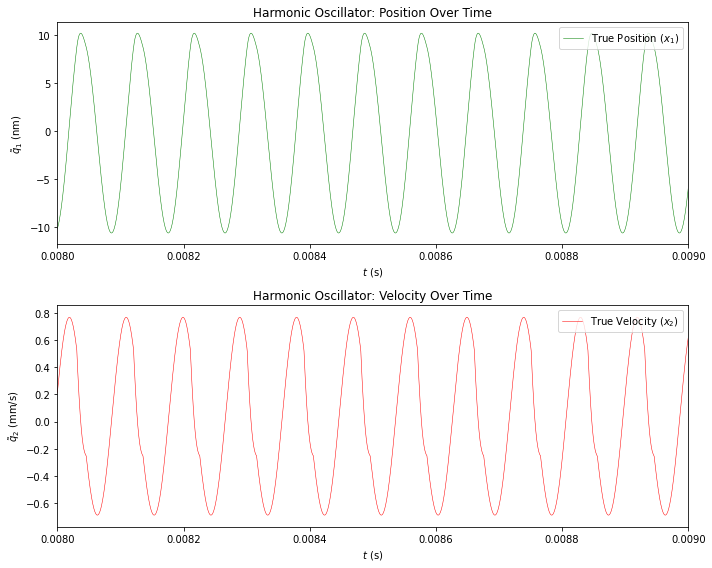

In [6]:
# Select the signal to plot:
signal = x_train_DMT_mult_traj[1] #one of the multiple generated trajectories
time = t_train_DMT

#Calculations to set the units back on the equation results
x_train_true_disp, true_t_train_DMT = get_true_AFM_displacement(signal[:,0], eta_star, tau_array=time, omega_0=w_0_cant)
x_train_true_vel, true_t_train_DMT = get_true_AFM_velocity(signal[:,1], eta_star, tau_array=time, omega_0=w_0_cant)
x_train_true_vel = x_train_true_vel*(1e-9)*(1000) #for velcolity in [mm/s]

# Setup the figure and subplots
set_plot_style()
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 Rows, 1 Column

# First subplot for Position
axs[0].plot(true_t_train_DMT, x_train_true_disp, linewidth=0.5, label='True Position ($x_1$)', color = 'g')
axs[0].set_xlabel(r'$t$ (s)')
axs[0].set_ylabel(r'$\tilde{q}_1$ (nm)')
axs[0].legend(loc = 'upper right')
axs[0].set_title('Harmonic Oscillator: Position Over Time')
axs[0].set_xlim([0.008, 0.009])

# Second subplot for Velocity
axs[1].plot(true_t_train_DMT, x_train_true_vel, linewidth=0.5, label='True Velocity ($x_2$)', color = 'r')
axs[1].set_xlabel(r'$t$ (s)')
axs[1].set_ylabel(r'$\tilde{q}_2$ (mm/s)')
axs[1].legend(loc = 'upper right')
axs[1].set_title('Harmonic Oscillator: Velocity Over Time')
axs[1].set_xlim([0.008, 0.009])
plt.tight_layout() 
file_name = 'simple_oscillator_2_1st try'
# plt.savefig(f't_{file_name}.jpg', dpi=300, bbox_inches='tight') #to save the image if needed

## Creation of trajectory Clusters

### Placing Cluster Centers

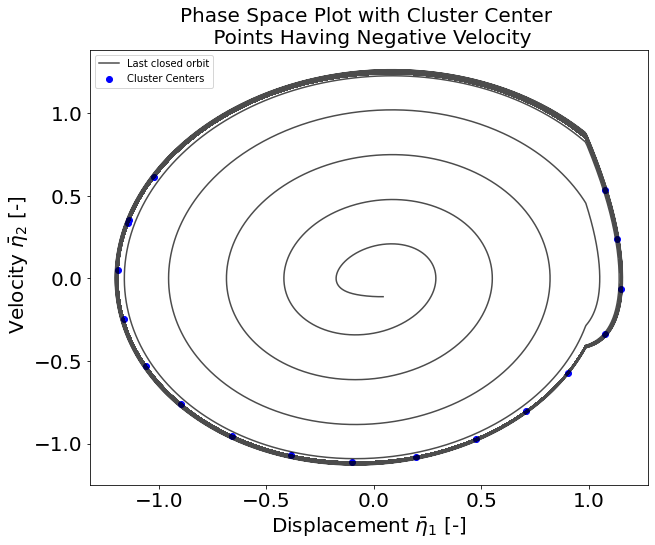

18


In [7]:
mult_traj_cluster_centers_x, mult_traj_cluster_centers_y = define_cluster_centers(x_train_mult_trajectories = x_train_DMT_mult_traj, num_points_high_res=800, 
                                                              sub_sample_val=30, filter_vel_max_val = 0.7, index_to_plot = 0, centers_loc = 3,
                                                              plot_file_name = None, plot=True, save_plot=False, multiple_init_cond =True)

print(len(mult_traj_cluster_centers_x[0]))

## Filter extra points from clustering

In [8]:
# Flatten the lists and combine each corresponding x and y into a single list of tuples
combined_x = np.hstack(mult_traj_cluster_centers_x)
combined_y = np.hstack(mult_traj_cluster_centers_y)

# Filter points
filtered_x, filtered_y = filter_close_points(combined_x, combined_y)

### Generating cluster from cluster centers

In [9]:
mult_traj_clusters_sections, mult_traj_clusters_dots_list = generate_fixed_clusters_from_centers(cluster_size= 18, x_train_mult_trajectories = x_train_DMT_mult_traj[0],
                                                                                                 KNN_neighbors_num = 400, KNN_radius = 1, 
                                                                                                 mult_traj_cluster_centers_x = filtered_x,
                                                                                                 mult_traj_cluster_centers_y = filtered_y,
                                                                                                 multiple_init_cond = False)

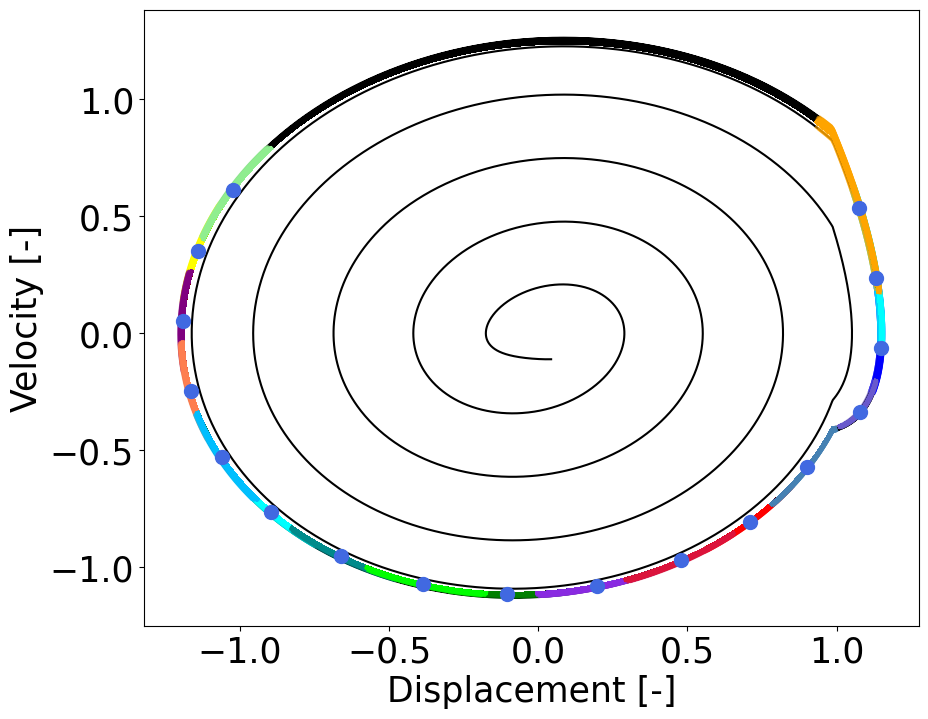

In [10]:
from itertools import cycle
set_plot_style()

traject = 0

fig, axs = plt.subplots(1, 1, figsize=(10, 8))

# plt.axvline(x=(1-a0), color='black', linestyle='--', label=f'Intermolecular Dist')
axs.plot(x_train_DMT_mult_traj[traject][:,0], x_train_DMT_mult_traj[traject][:,1], color = 'black', linewidth=1.5, alpha = 1, zorder=1)

colors = cycle(['yellow', 'blue', 'red', 'green', 'cyan', 'purple', 'aqua', 'steelblue', 'blueviolet', 'darkcyan', 'coral',
    'lightgreen', 'orange', 'slateblue', 'crimson', 'lime', 'deepskyblue'
])

for cluster in range(len(mult_traj_clusters_sections[traject])):
    current_color = next(colors)  # Get the next color from the cycle
    for cluster_dot in range(len(mult_traj_clusters_sections[traject][cluster])):
        axs.plot(mult_traj_clusters_sections[traject][cluster][cluster_dot][:,0], mult_traj_clusters_sections[traject][cluster][cluster_dot][:,1], color = current_color, linewidth=2.5, alpha =0.6, zorder=2)
    axs.plot(mult_traj_cluster_centers_x[traject][cluster], mult_traj_cluster_centers_y[traject][cluster], '.', color = 'royalblue', markersize = 20, zorder=3)

axs.set_xlabel(r'Displacement [-]', fontsize=25)
axs.set_ylabel(r'Velocity [-]', fontsize=25)

# Customizing tick labels size
axs.tick_params(axis='both', which='major', labelsize=25)  # Customize the font size of the tick labels
axs.tick_params(axis='both', which='major', labelsize=25)  # Customize the font size of the tick label

# Saving the figure with a transparent background
# plt.savefig('Fig_1_DMT_synthetic_data_phase_space_mult_clusters_w_centers_no_symbols_17_clusters_XX.png', transparent=True, dpi=300, bbox_inches='tight')

# Import trained models in clusters

In [ ]:
found_models_df = pd.DataFrame(columns=['Candidate Model', 'Model Type', 'Serial No.', 'Cluster No.', 'Lambda', 'Nu', 'Parsimony'])
found_models_df = import_trained_models_from_folder_to_dataframe(folder_path = '/Users/santiago/Documents/PhD_documents/Python_Simulations/Learning_SINDy/Github_Repository',
                                                                 folder_name = 'attractive_model_no_viscoelastic_terms_17_clusters',
                                                                 new_dataframe = found_models_df, number_of_parsimony_eq = 2)

### Divide data in Dataframe accourding to their Clusters

In [12]:
# Filter rows where 'Cluster No.' is 0
found_models_C0_df = found_models_df[found_models_df['Cluster No.'] == '0'].copy()

# Filter rows where 'Cluster No.' is 1
found_models_C1_df = found_models_df[found_models_df['Cluster No.'] == '1'].copy()

# Filter rows where 'Cluster No.' is 2
found_models_C2_df = found_models_df[found_models_df['Cluster No.'] == '2'].copy()

# Filter rows where 'Cluster No.' is 3
found_models_C3_df = found_models_df[found_models_df['Cluster No.'] == '3'].copy()

# Filter rows where 'Cluster No.' is 4
found_models_C4_df = found_models_df[found_models_df['Cluster No.'] == '4'].copy()

# Filter rows where 'Cluster No.' is 5
found_models_C5_df = found_models_df[found_models_df['Cluster No.'] == '5'].copy()

# Filter rows where 'Cluster No.' is 6
found_models_C6_df = found_models_df[found_models_df['Cluster No.'] == '6'].copy()

# Filter rows where 'Cluster No.' is 7
found_models_C7_df = found_models_df[found_models_df['Cluster No.'] == '7'].copy()

# Filter rows where 'Cluster No.' is 8
found_models_C8_df = found_models_df[found_models_df['Cluster No.'] == '8'].copy()

# Filter rows where 'Cluster No.' is 9
found_models_C9_df = found_models_df[found_models_df['Cluster No.'] == '9'].copy()

# Filter rows where 'Cluster No.' is 10
found_models_C10_df = found_models_df[found_models_df['Cluster No.'] == '10'].copy()

# Filter rows where 'Cluster No.' is 11
found_models_C11_df = found_models_df[found_models_df['Cluster No.'] == '11'].copy()

# Filter rows where 'Cluster No.' is 12
found_models_C12_df = found_models_df[found_models_df['Cluster No.'] == '12'].copy()

# Filter rows where 'Cluster No.' is 13
found_models_C13_df = found_models_df[found_models_df['Cluster No.'] == '13'].copy()

# Filter rows where 'Cluster No.' is 14
found_models_C14_df = found_models_df[found_models_df['Cluster No.'] == '14'].copy()

# Filter rows where 'Cluster No.' is 15
found_models_C15_df = found_models_df[found_models_df['Cluster No.'] == '15'].copy()

# Filter rows where 'Cluster No.' is 16
found_models_C16_df = found_models_df[found_models_df['Cluster No.'] == '16'].copy()

# Filter rows where 'Cluster No.' is 17
found_models_C17_df = found_models_df[found_models_df['Cluster No.'] == '17'].copy()

## Analysis for Cluster No. 0

In [13]:
found_models_C0_df = mark_unique_models_in_dataframe(found_models_C0_df)

# Now filter unique models:
unique_models_C0_df = found_models_C0_df[found_models_C0_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C0_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



In [14]:
repeated_models_C0_df = found_models_C0_df[~found_models_C0_df['Is Unique']]
print('A total of ' + str(len(repeated_models_C0_df['Candidate Model'])) + ' repeated models were found')
print('')

A total of 0 repeated models were found



## AIC analysis for all models within one cluster: Cluster 0

In [15]:
unique_models_to_analyze = unique_models_C0_df
analyzed_cluster = 0

simulated_information_C0, error_information_C0, AIC_models_in_cluster_C0 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Normal DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2)

rel_AIC_c_lst_C0 = get_relative_AIC_c_score(AIC_models_in_cluster_C0)

unique_models_C0_df['Delta_AIC_c'] = rel_AIC_c_lst_C0

Processing models: 100%|██████████| 100/100 [00:25<00:00,  3.90model/s]


## Best models within Cluster 0

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model.

In [ ]:
# Filter rows where 'Delta AIC_c' is less than 1
pd.set_option('display.max_rows', None)
best_rel_AIC_c_C0_df = unique_models_C0_df[unique_models_C0_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C0_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony Lambda   Nu  Delta_AIC_c
0  24-01-25-004-0           0         6  0.001  0.1          0.0

## Simulation of one of these candidate models for cluster 0

rms was: 4.639030330291061
switch_ind was: 194

Equation with length: 6
(e1)' = 1.000000000 e2
(e2)' = 0.001544675 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + -0.007282700 (1-e1)^-2 + 0.022012900 (1-e1)^-3
(phase)' = 1.000000000 1



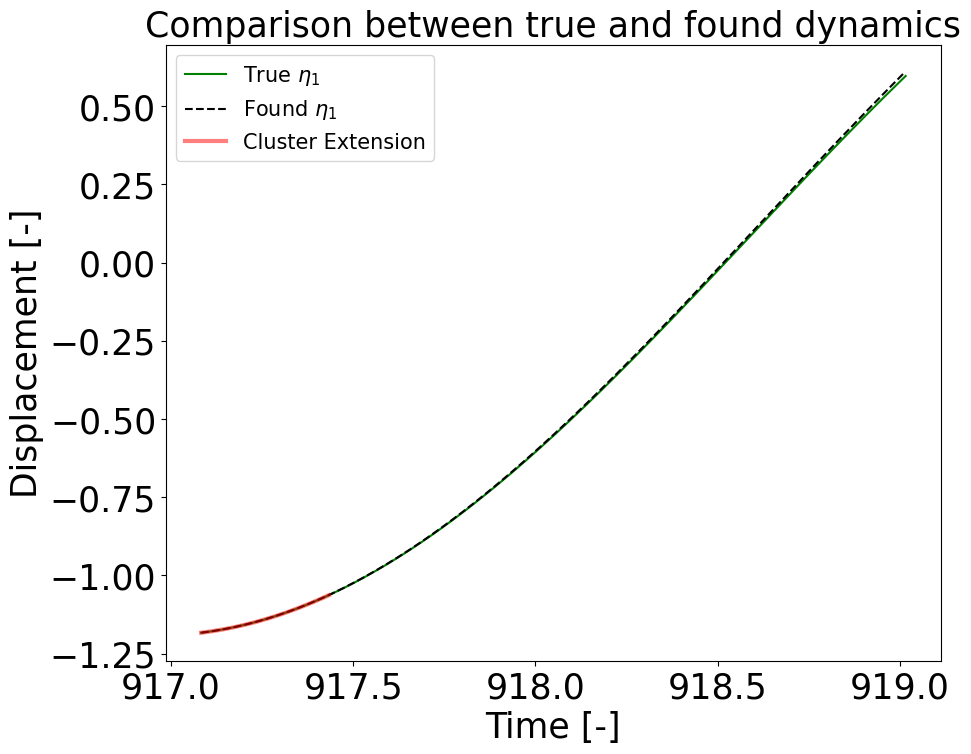

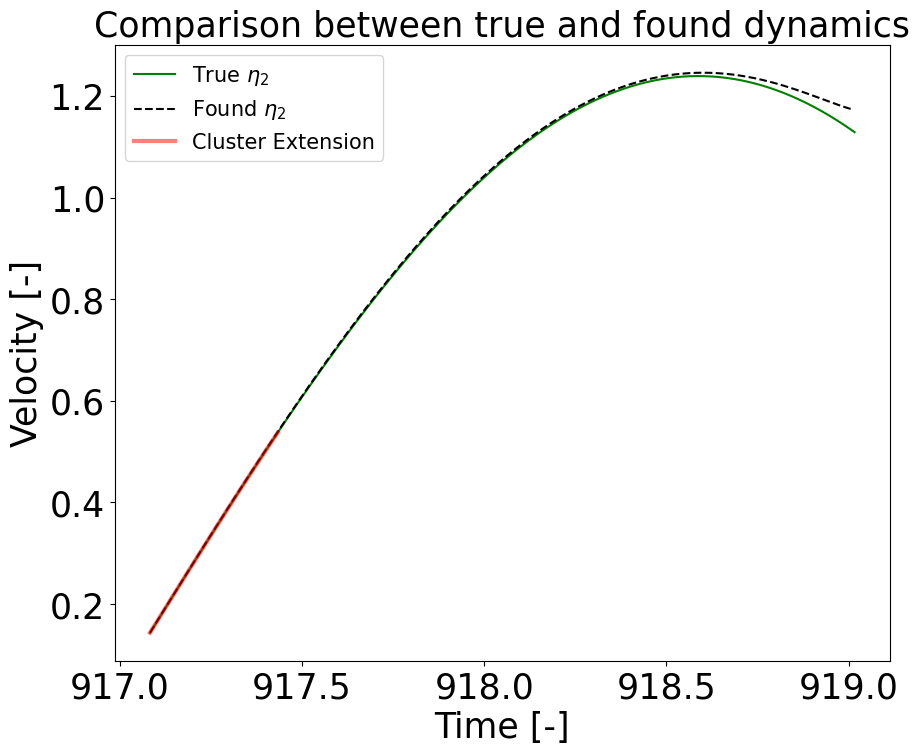

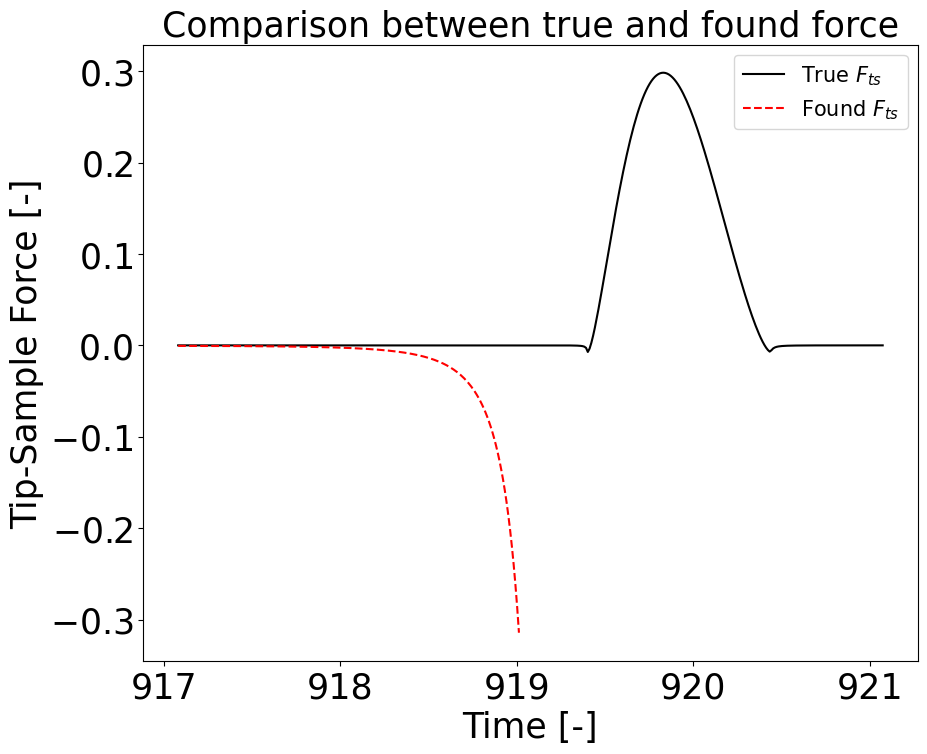

In [17]:
model_to_study = best_rel_AIC_c_C0_df['Candidate Model'][0]
cluster_to_test = 0

simulated_data_C0, extended_val_trajec_C0, F_ts_true_C0, F_ts_sim_C0 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2, 
                                                 plot = True)

## Analysis for Cluster No. 1

In [18]:
found_models_C1_df = mark_unique_models_in_dataframe(found_models_C1_df)

# Now filter unique models:
unique_models_C1_df = found_models_C1_df[found_models_C1_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C1_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



### Checking repeated models

In [19]:
repeated_models_C1_df = found_models_C1_df[~found_models_C1_df['Is Unique']]
print('A total of ' + str(len(repeated_models_C1_df['Candidate Model'])) + ' repeated models were found')
print('')

A total of 0 repeated models were found



## AIC analysis for all models within one cluster: Cluster 1

In [20]:
unique_models_to_analyze = unique_models_C1_df
analyzed_cluster = 1

simulated_information_C1, error_information_C1, AIC_models_in_cluster_C1 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Normal DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2)

rel_AIC_c_lst_C1 = get_relative_AIC_c_score(AIC_models_in_cluster_C1)

unique_models_C1_df['Delta_AIC_c'] = rel_AIC_c_lst_C1

Processing models: 100%|██████████| 100/100 [00:21<00:00,  4.76model/s]


## Best models within Cluster 1

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [21]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C1_df = unique_models_C1_df[unique_models_C1_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C1_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                  Lambda  \
0  25-01-25-091-1           1         7                   1e-07   
1  24-01-25-018-1           1         7  0.00012915496650148828   
2  25-01-25-097-1           1         7                   1e-07   
3  24-01-25-001-1           1         7                   0.001   

                     Nu  Delta_AIC_c  
0  0.016681005372000592     0.000000  
1  0.021544346900318832     0.256518  
2  0.027825594022071243     0.725708  
3  0.016681005372000592     0.091347

## Simulation of one of these candidate models for cluster 1

rms was: 0.1817837888128123
switch_ind was: 4

Equation with length: 7
(e1)' = 1.000000000 e2
(e2)' = 0.108167826 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + -2.450498771 (0.0132626-1+e1)^1.5 + -3.763616923 (0.0132626-1+e1)^2 + -5.741783397 (0.0132626-1+e1)^2.5
(phase)' = 1.000000000 1



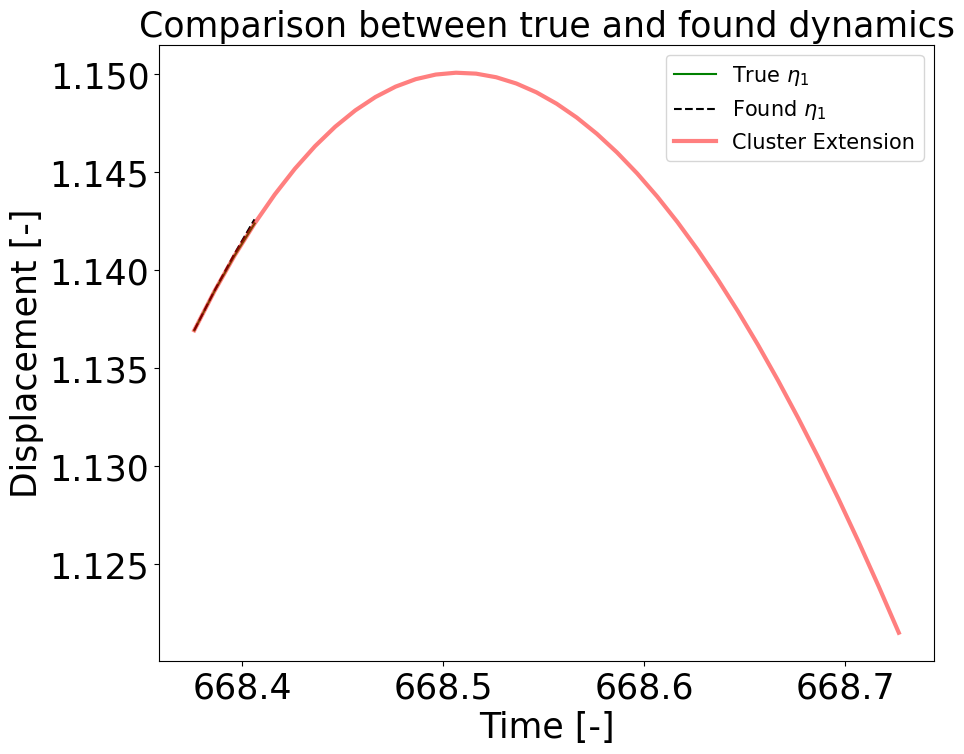

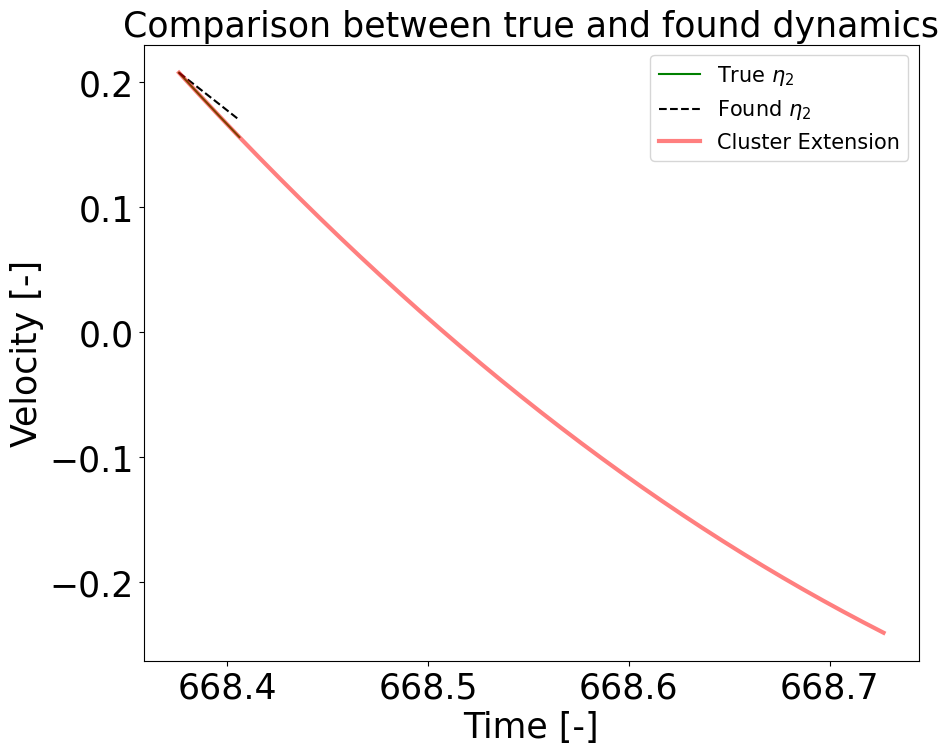

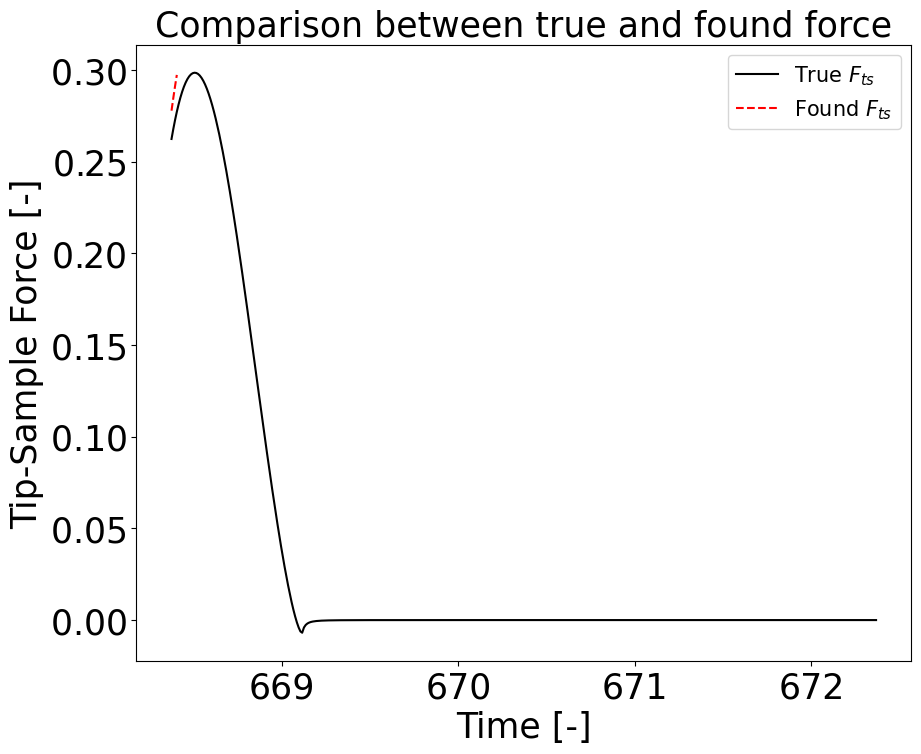

In [22]:
%run /Users/santiago/Documents/PhD_documents/Python_Simulations/Learning_SINDy/SINDY_example_functions.ipynb
model_to_study = best_rel_AIC_c_C1_df['Candidate Model'][0]
cluster_to_test = 1

simulated_data_C1, extended_val_trajec_C1, F_ts_true_C1, F_ts_sim_C1 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2, force_plot_file_name = 'force_green', disp_plot_file_name = 'disp_green', vel_plot_file_name = 'vel_green',
                                                 plot = True, save=False)

## Analysis for Cluster No. 2

In [23]:
found_models_C2_df = mark_unique_models_in_dataframe(found_models_C2_df)

# Now filter unique models:
unique_models_C2_df = found_models_C2_df[found_models_C2_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C2_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 35 unique models were found



### Checking repeated models

In [24]:
repeated_models_C2_df = found_models_C2_df[~found_models_C2_df['Is Unique']]
print('A total of ' + str(len(repeated_models_C2_df['Candidate Model'])) + ' repeated models were found')
print('')

A total of 65 repeated models were found



## AIC analysis for all models within one cluster: Cluster 2

In [25]:
unique_models_to_analyze = unique_models_C2_df
analyzed_cluster = 2

simulated_information_C2, error_information_C2, AIC_models_in_cluster_C2 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-5, model_type = 'Normal DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2)

rel_AIC_c_lst_C2 = get_relative_AIC_c_score(AIC_models_in_cluster_C2)

unique_models_C2_df['Delta_AIC_c'] = rel_AIC_c_lst_C2

Processing models: 100%|██████████| 35/35 [00:05<00:00,  6.21model/s]


## Best models within Cluster 2

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model.

In [ ]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C2_df = unique_models_C2_df[unique_models_C2_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C2_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                 Lambda  \
0  25-01-25-028-2           2         5  2.782559402207126e-07   
1  25-01-25-099-2           2         6                  1e-07   
2  25-01-25-021-2           2         5  2.782559402207126e-07   
3  25-01-25-098-2           2         6                  1e-07   
4  25-01-25-095-2           2         6                  1e-07   
5  25-01-25-091-2           2         6                  1e-07   
6  25-01-25-024-2           2         6  2.782559402207126e-07   
7  25-01-25-093-2           2         6                  1e-07   
8  25-01-25-090-2           2         5                  1e-07   

                     Nu  Delta_AIC_c  
0  0.021544346900318832     0.269458  
1   0.03593813663804628     0.913480  
2  0.016681005372000592     0.000000  
3  0.021544346900318832     0.756323  
4    0.0774263682681127     0.914567  
5  0.016681005372000592     0.943242  
6                   0.1     0.698566  
7  0.046415888336127774     0.870326  
8                  0.01     0.099949

## Simulation of one of these candidate models for cluster 2

rms was: 0.0002880060582456113
switch_ind was: 400

Equation with length: 5
(e1)' = 1.000000000 e2
(e2)' = -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + 0.000004623 (1-e1)^-2 + -0.000000553 (1-e1)^-3
(phase)' = 1.000000000 1



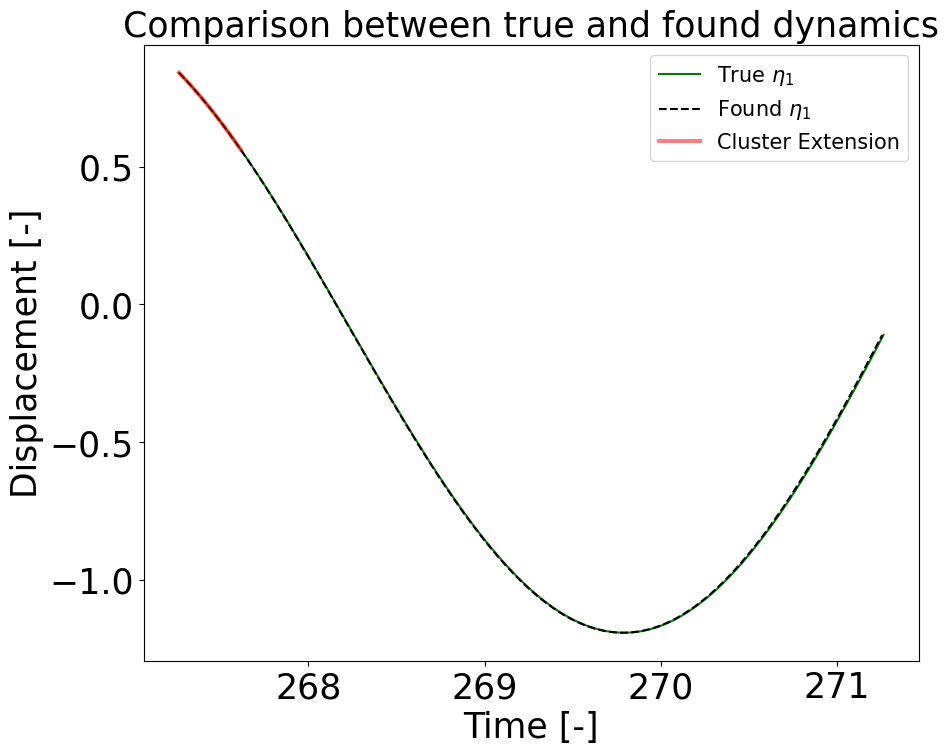

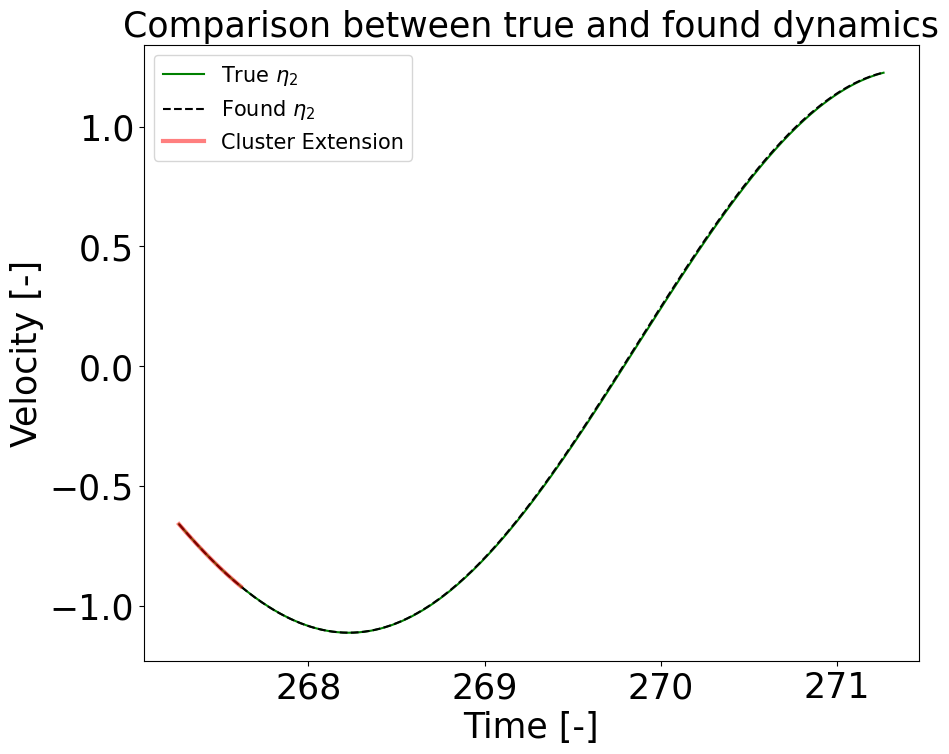

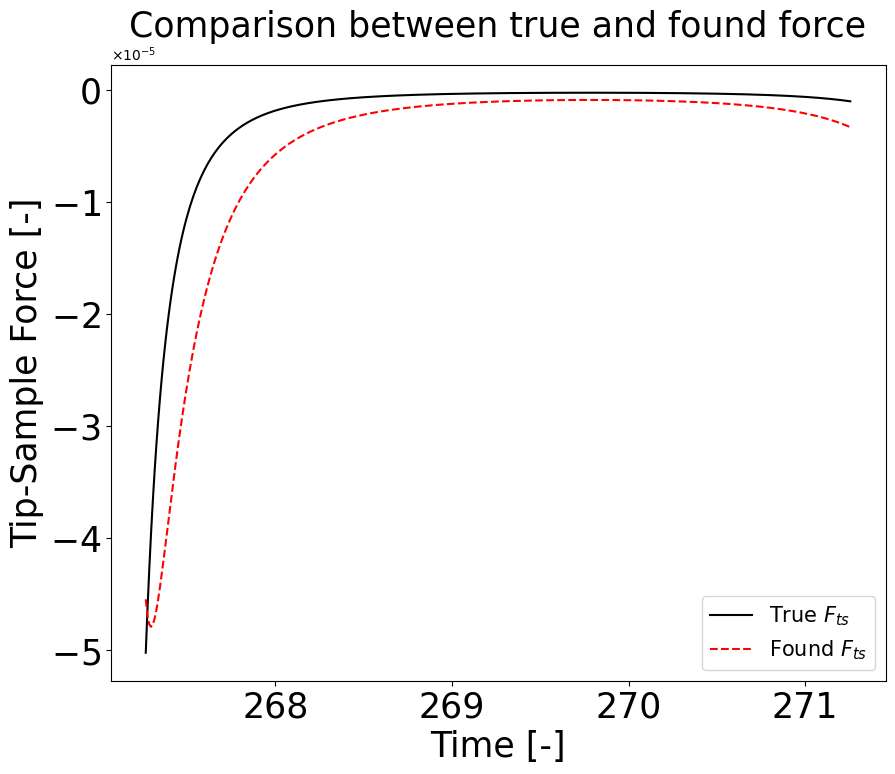

In [27]:
model_to_study = best_rel_AIC_c_C2_df['Candidate Model'][0]
cluster_to_test = 2

simulated_data_C2, extended_val_trajec_C2, F_ts_true_C2, F_ts_sim_C2 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2, 
                                                 plot = True)

## Analysis for Cluster No. 3

In [28]:
found_models_C3_df = mark_unique_models_in_dataframe(found_models_C3_df)

# Now filter unique models:
unique_models_C3_df = found_models_C3_df[found_models_C3_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C3_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 85 unique models were found



### Checking repeated models

In [29]:
repeated_models_C3_df = found_models_C3_df[~found_models_C3_df['Is Unique']]
print('A total of ' + str(len(repeated_models_C3_df['Candidate Model'])) + ' repeated models were found')
print('')

A total of 15 repeated models were found



## AIC analysis for all models within one cluster: Cluster 3

In [30]:
unique_models_to_analyze = unique_models_C3_df
analyzed_cluster = 3

simulated_information_C3, error_information_C3, AIC_models_in_cluster_C3 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Normal DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2)

rel_AIC_c_lst_C3 = get_relative_AIC_c_score(AIC_models_in_cluster_C3)

unique_models_C3_df['Delta_AIC_c'] = rel_AIC_c_lst_C3

Processing models: 100%|██████████| 85/85 [00:17<00:00,  4.96model/s]


## Best models within Cluster 3

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model.

In [ ]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C3_df = unique_models_C3_df[unique_models_C3_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C3_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                  Lambda    Nu  \
0  25-01-25-030-3           3         3  0.00035938136638046257  0.01   

   Delta_AIC_c  
0          0.0

## Simulation of one of these candidate models for cluster 3

rms was: 0.00018807972860178601
switch_ind was: 400

Equation with length: 3
(e1)' = 1.000000000 e2
(e2)' = -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase)
(phase)' = 1.000000000 1



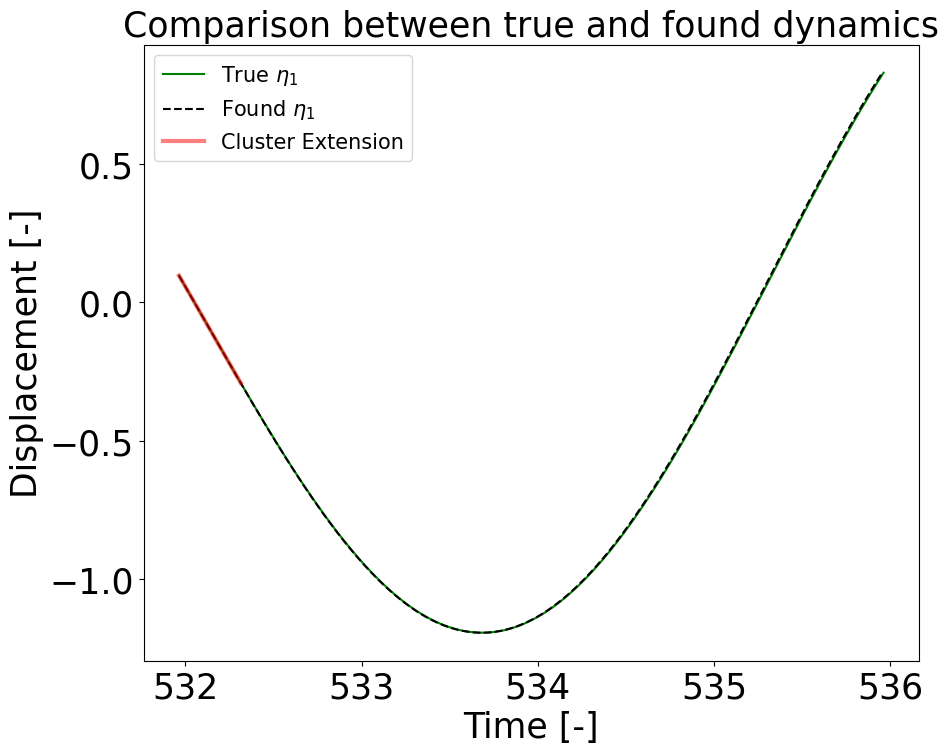

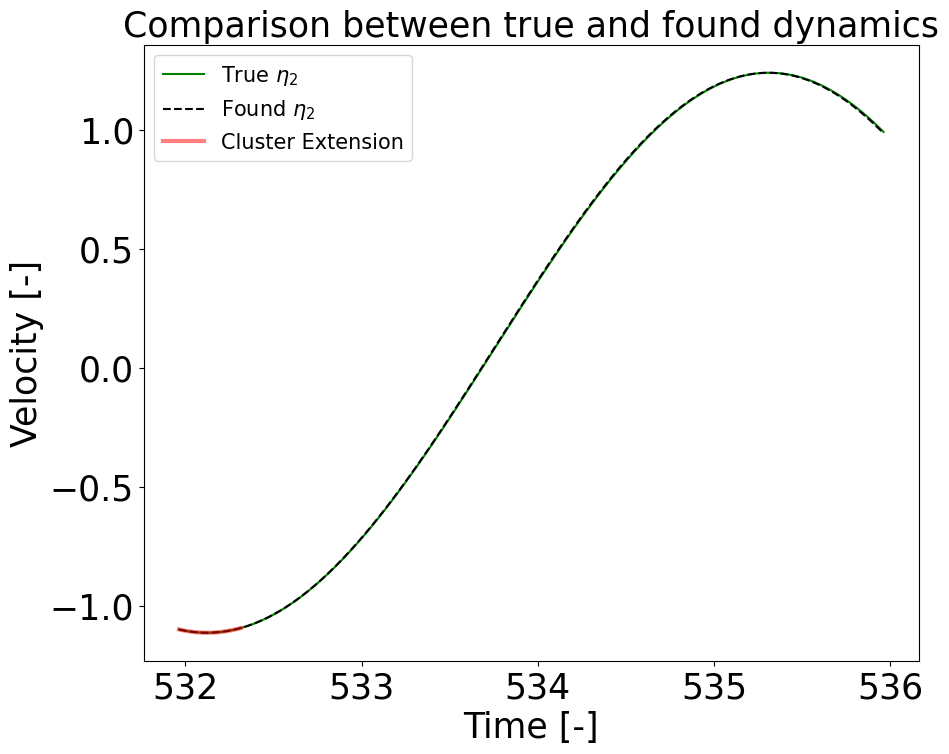

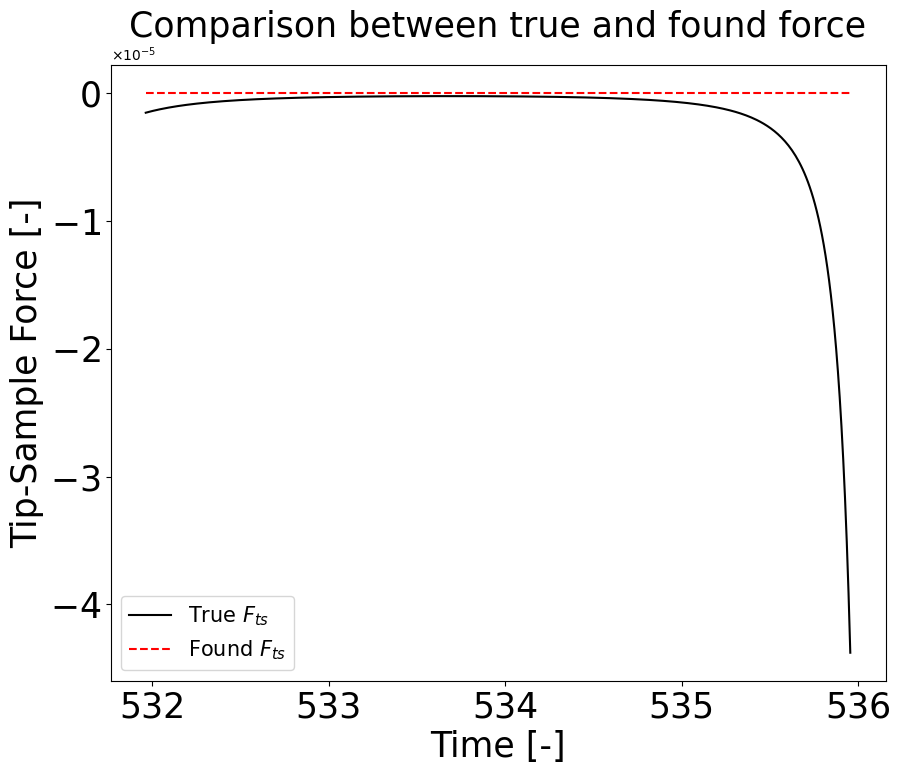

In [32]:
model_to_study = best_rel_AIC_c_C3_df['Candidate Model'][0]
cluster_to_test = 3

simulated_data_C3, extended_val_trajec_C3, F_ts_true_C3, F_ts_sim_C3 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2, 
                                                 plot = True)

## Analysis for Cluster No. 4

In [33]:
found_models_C4_df = mark_unique_models_in_dataframe(found_models_C4_df)

# Now filter unique models
unique_models_C4_df = found_models_C4_df[found_models_C4_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C4_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 97 unique models were found



### Checking repeated models

In [34]:
repeated_models_C4_df = found_models_C4_df[~found_models_C4_df['Is Unique']]
print('A total of ' + str(len(repeated_models_C4_df['Candidate Model'])) + ' repeated models were found')
print('')

A total of 3 repeated models were found



## AIC analysis for all models within one cluster: Cluster 4

In [35]:
unique_models_to_analyze = unique_models_C4_df
analyzed_cluster = 4

simulated_information_C4, error_information_C4, AIC_models_in_cluster_C4 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Normal DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2)

rel_AIC_c_lst_C4 = get_relative_AIC_c_score(AIC_models_in_cluster_C4)

unique_models_C4_df['Delta_AIC_c'] = rel_AIC_c_lst_C4

Processing models: 100%|██████████| 97/97 [00:23<00:00,  4.14model/s]


In [36]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C4_df = unique_models_C4_df[unique_models_C4_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C4_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                  Lambda  \
0  25-01-25-036-4           4         3  0.00035938136638046257   

                    Nu  Delta_AIC_c  
0  0.05994842503189409          0.0

## Simulation of one of these candidate models for cluster 4

rms was: 0.12582183462747726
switch_ind was: 343

Equation with length: 3
(e1)' = 1.000000000 e2
(e2)' = -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase)
(phase)' = 1.000000000 1



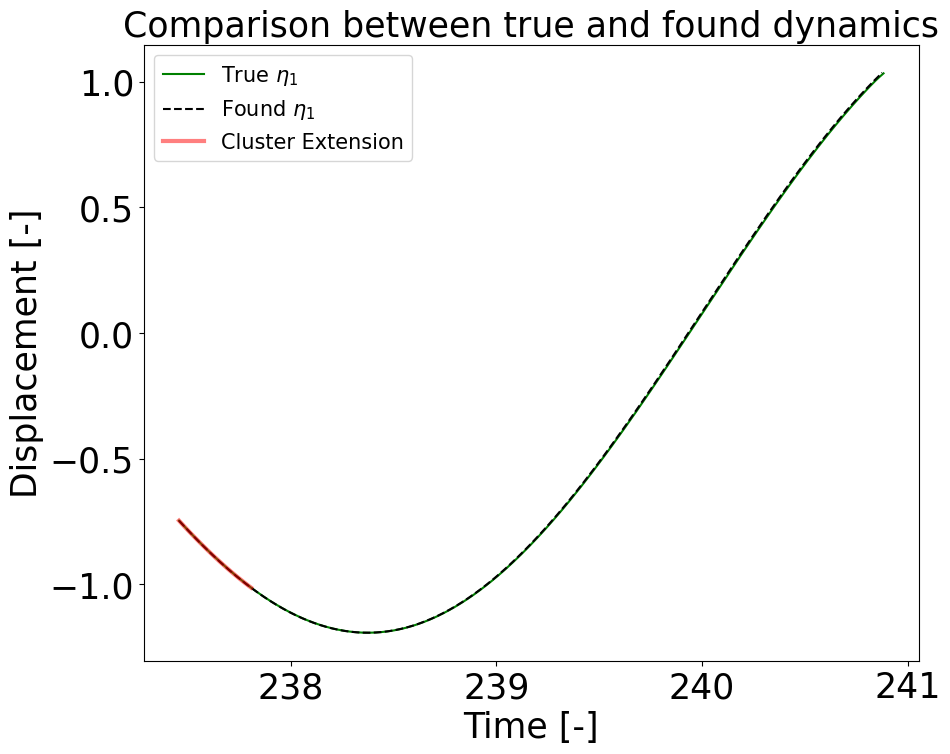

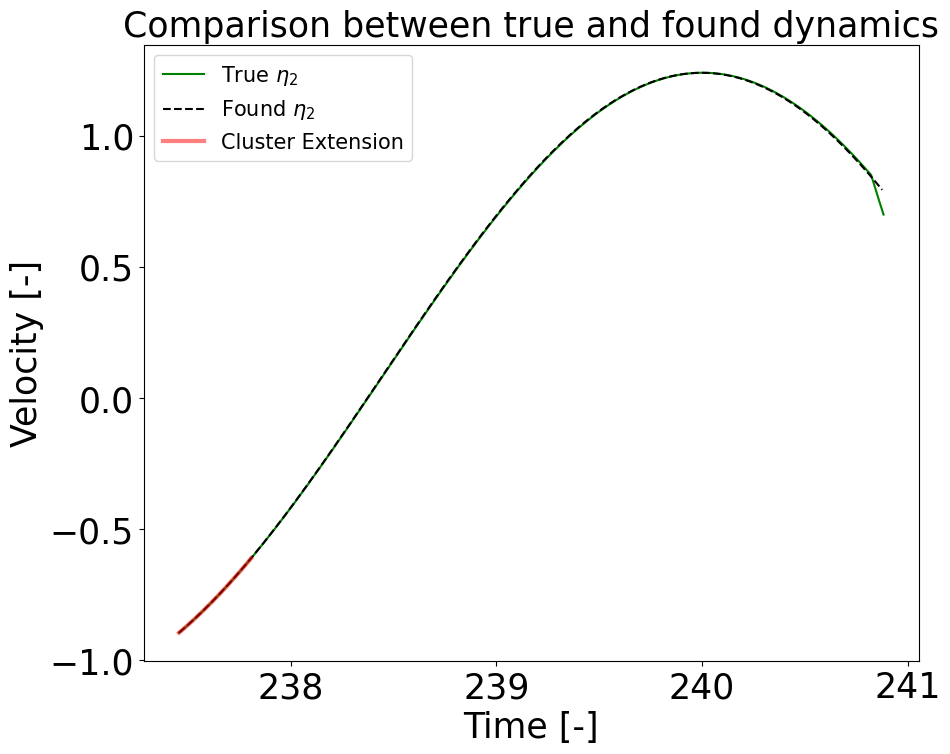

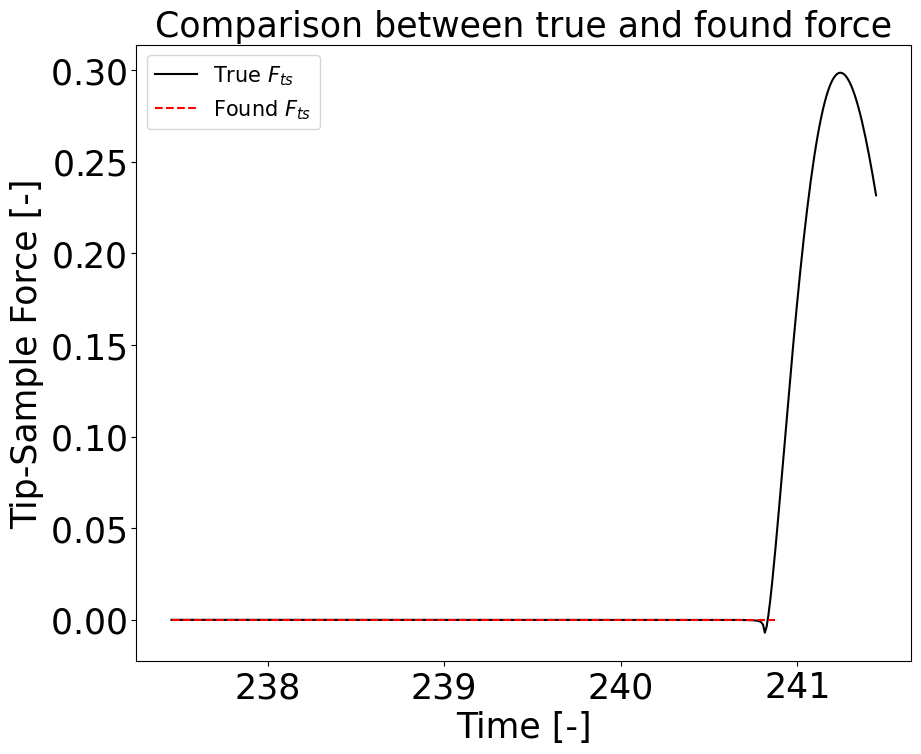

In [37]:
model_to_study = best_rel_AIC_c_C4_df['Candidate Model'][0] 
cluster_to_test = 4

simulated_data_C4, extended_val_trajec_C4, F_ts_true_C4, F_ts_sim_C4 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2, force_plot_file_name = 'force_rep', disp_plot_file_name = 'disp_rep', vel_plot_file_name = 'vel_rep',
                                                 plot = True, F_xlim = None, save = False)

## Analysis for Cluster No. 5

In [38]:
found_models_C5_df = mark_unique_models_in_dataframe(found_models_C5_df)

# Now filter unique models
unique_models_C5_df = found_models_C5_df[found_models_C5_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C5_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



### Checking repeated models

In [39]:
repeated_models_C5_df = found_models_C5_df[~found_models_C5_df['Is Unique']]
print('A total of ' + str(len(repeated_models_C5_df['Candidate Model'])) + ' repeated models were found')
print('')

A total of 0 repeated models were found



## AIC analysis for all models within Cluster 5

In [40]:
unique_models_to_analyze = unique_models_C5_df
analyzed_cluster = 5

simulated_information_C5, error_information_C5, AIC_models_in_cluster_C5 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Normal DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2)

rel_AIC_c_lst_C5 = get_relative_AIC_c_score(AIC_models_in_cluster_C5)

unique_models_C5_df['Delta_AIC_c'] = rel_AIC_c_lst_C5

Processing models: 100%|██████████| 100/100 [00:26<00:00,  3.76model/s]


## Best models within Cluster 5

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [41]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C5_df = unique_models_C5_df[unique_models_C5_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C5_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                 Lambda  \
0  25-01-25-051-5           5         6  5.994842503189409e-06   

                     Nu  Delta_AIC_c  
0  0.016681005372000592          0.0

## Simulation of one of these candidate models for cluster 5

rms was: 5.533989893927172
switch_ind was: 39

Equation with length: 6
(e1)' = 1.000000000 e2
(e2)' = 0.000399099 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + -0.013804519 (1-e1)^-2 + 0.031246193 (1-e1)^-3
(phase)' = 1.000000000 1



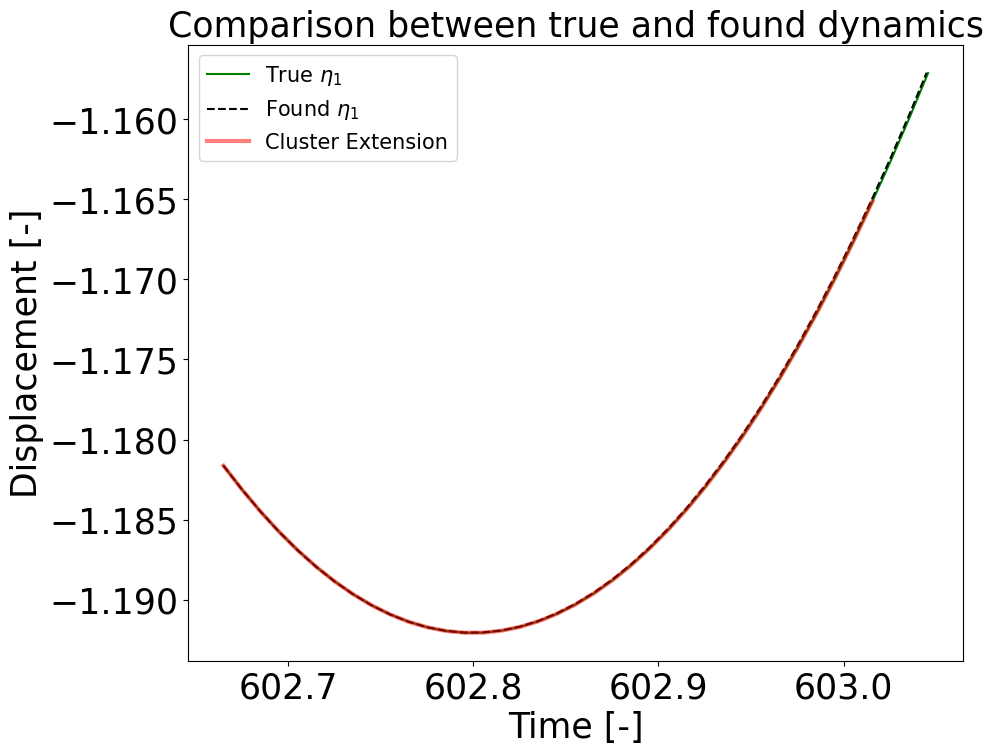

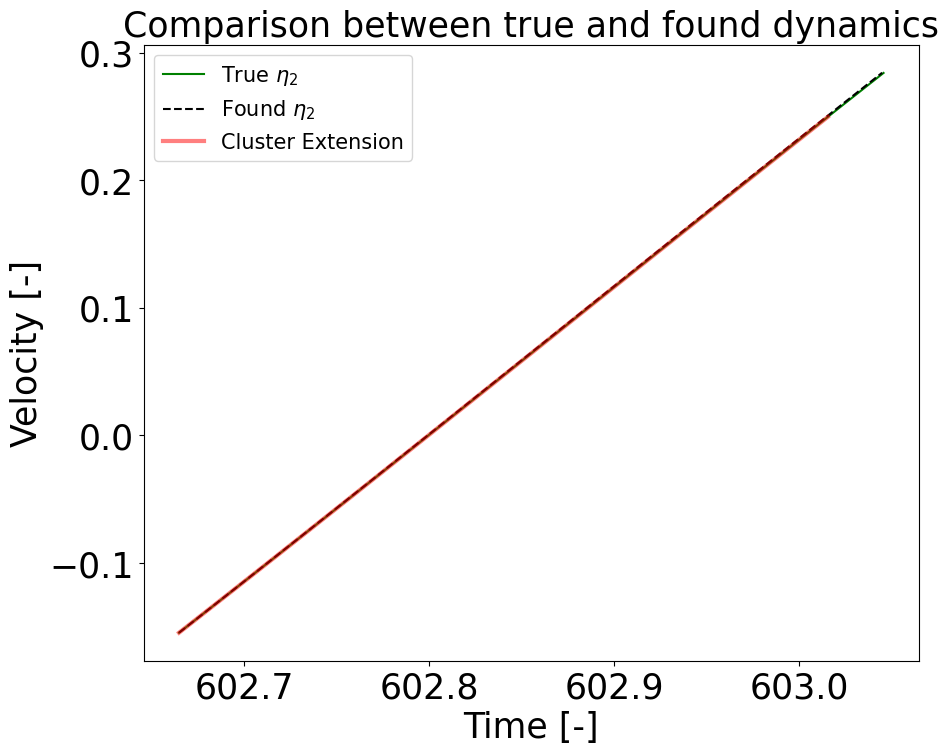

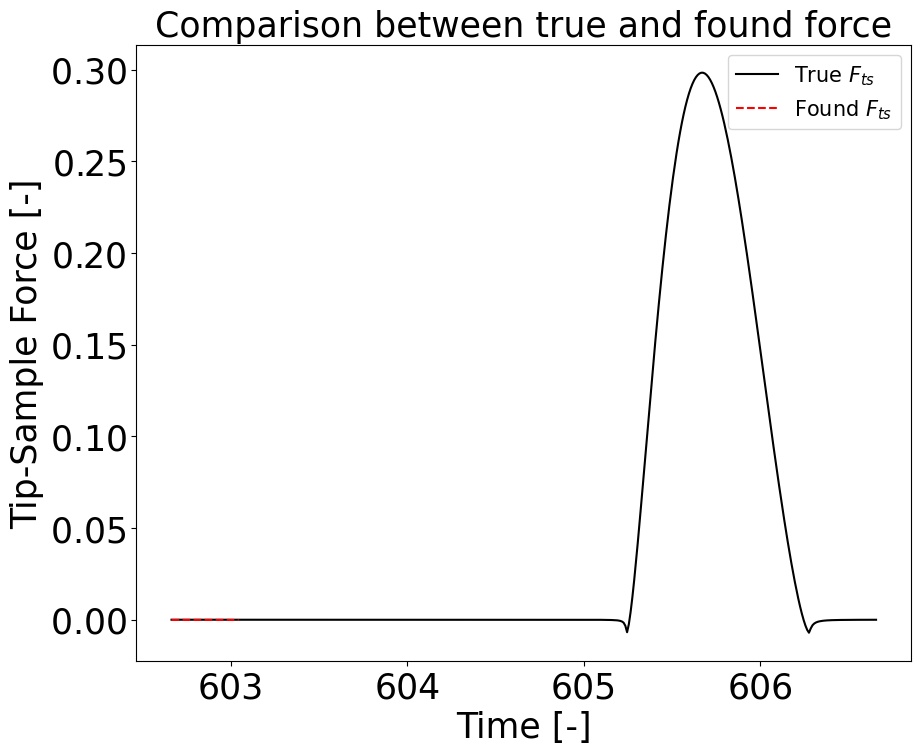

In [ ]:
model_to_study = best_rel_AIC_c_C5_df['Candidate Model'][0] 
cluster_to_test = 5

simulated_data_C5, extended_val_trajec_C5, F_ts_true_C5, F_ts_sim_C5 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-4,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2, force_plot_file_name = 'force_orange', disp_plot_file_name = 'disp_orange', vel_plot_file_name = 'vel_orange',
                                                 plot = True, F_xlim = None, save=False)

## Analysis for Cluster No. 6

In [43]:
found_models_C6_df = mark_unique_models_in_dataframe(found_models_C6_df)

# Now filter unique models
unique_models_C6_df = found_models_C6_df[found_models_C6_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C6_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



## AIC analysis for all models within one cluster: Cluster 6

In [44]:
unique_models_to_analyze = unique_models_C6_df
analyzed_cluster = 6

simulated_information_C6, error_information_C6, AIC_models_in_cluster_C6 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Normal DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2)

rel_AIC_c_lst_C6 = get_relative_AIC_c_score(AIC_models_in_cluster_C6)

unique_models_C6_df['Delta_AIC_c'] = rel_AIC_c_lst_C6

Processing models: 100%|██████████| 100/100 [00:20<00:00,  4.93model/s]


## Best models within Cluster 6

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [ ]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C6_df = unique_models_C6_df[unique_models_C6_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C6_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                  Lambda  \
0  25-01-25-060-6           6         7  2.1544346900318822e-06   
1  25-01-25-080-6           6         7   4.641588833612772e-05   
2  25-01-25-052-6           6         7   5.994842503189409e-06   
3  25-01-25-010-6           6         7  0.00012915496650148828   
4  25-01-25-082-6           6         7   4.641588833612772e-05   
5  25-01-25-020-6           6         7   2.782559402207126e-07   
6  25-01-25-090-6           6         7                   1e-07   
7  25-01-25-000-6           6         6                   0.001   
8  25-01-25-022-6           6         7   2.782559402207126e-07   

                    Nu  Delta_AIC_c  
0                 0.01     0.053793  
1                 0.01     0.273691  
2  0.01291549665014884     0.893254  
3                 0.01     0.082495  
4  0.01291549665014884     0.896820  
5                 0.01     0.000000  
6                 0.01     0.675164  
7                 0.01     0.519592  
8  0.01291549665014884     0.742798

## Simulation of one of these candidate models for cluster 6

rms was: 0.7939237178226657
switch_ind was: 7

Equation with length: 7
(e1)' = 1.000000000 e2
(e2)' = -1.170663325 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + 5.909990709 (0.0132626-1+e1)^1.5 + 4.572925448 (0.0132626-1+e1)^2 + 3.822365474 (0.0132626-1+e1)^2.5
(phase)' = 1.000000000 1



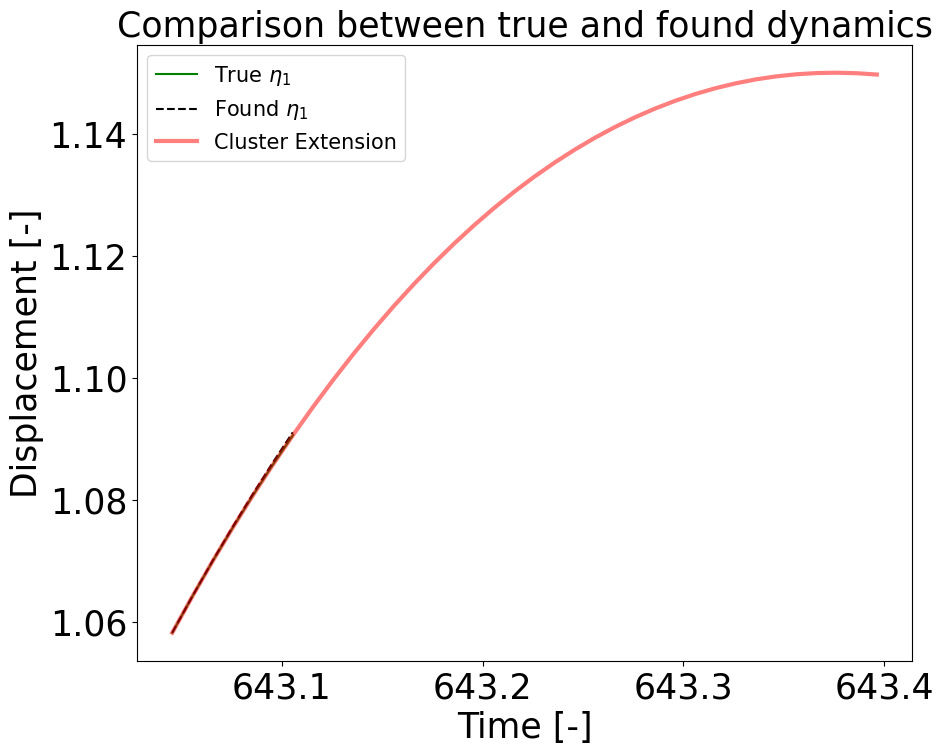

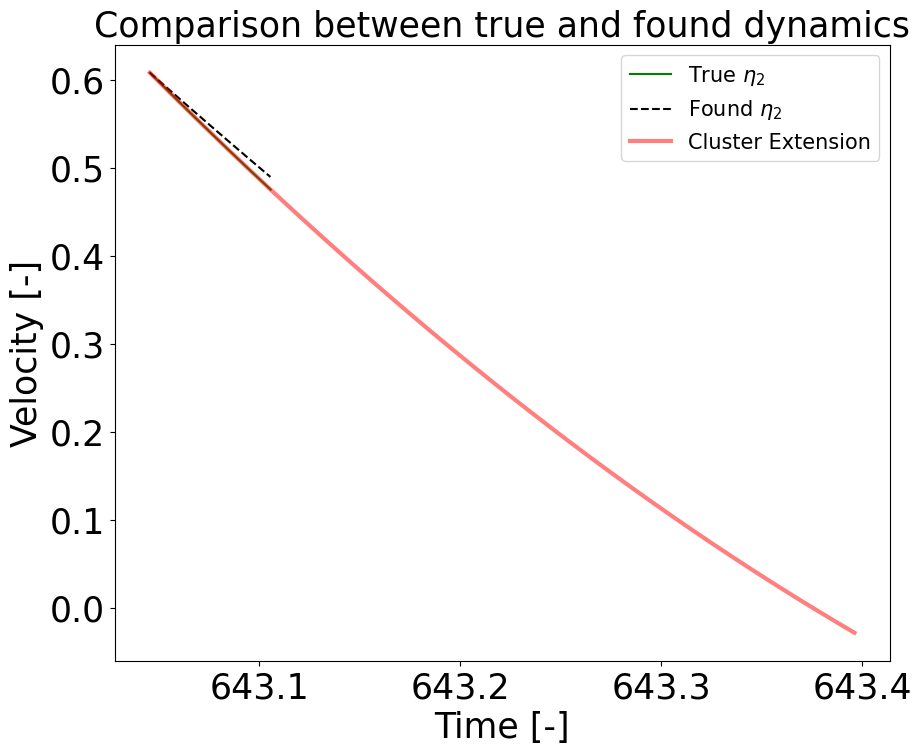

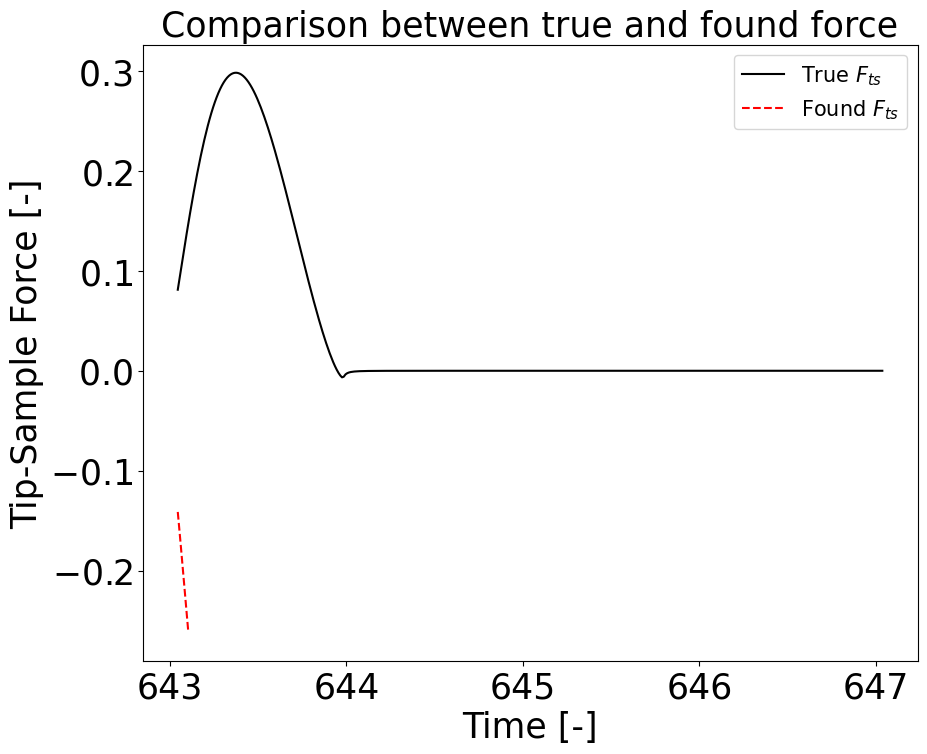

In [46]:
model_to_study = best_rel_AIC_c_C6_df['Candidate Model'][0]
cluster_to_test = 6

simulated_data_C6, extended_val_trajec_C6, F_ts_true_C6, F_ts_sim_C6 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2,
                                                 disp_plot_file_name= 'rep_aic_ts_disp_no_viscoelastic_terms', vel_plot_file_name = 'rep_aic_ts_vel_no_viscoelastic_terms', force_plot_file_name= 'rep_aic_ts_force_no_viscoelastic_terms',
                                                 plot = True, save=False)

## Analysis for Cluster No. 7

In [47]:
found_models_C7_df = mark_unique_models_in_dataframe(found_models_C7_df)

# Now filter unique models
unique_models_C7_df = found_models_C7_df[found_models_C7_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.
print('A total of ' + str(len(unique_models_C7_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 57 unique models were found



## AIC analysis for all models within one cluster: Cluster 7

In [48]:
unique_models_to_analyze = unique_models_C7_df
analyzed_cluster = 7

simulated_information_C7, error_information_C7, AIC_models_in_cluster_C7 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Normal DMT',# 1e-2
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2)

rel_AIC_c_lst_C7 = get_relative_AIC_c_score(AIC_models_in_cluster_C7)

unique_models_C7_df['Delta_AIC_c'] = rel_AIC_c_lst_C7

Processing models: 100%|██████████| 57/57 [00:09<00:00,  6.11model/s]


## Best models within Cluster 7

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [ ]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C7_df = unique_models_C7_df[unique_models_C7_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C7_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                  Lambda  \
0   25-01-25-065-7           7         7  2.1544346900318822e-06   
1   25-01-25-056-7           7         4   5.994842503189409e-06   
2   25-01-25-006-7           7         4                   0.001   
3   25-01-25-036-7           7         3  0.00035938136638046257   
4   25-01-25-020-7           7         5   2.782559402207126e-07   
5   25-01-25-055-7           7         5   5.994842503189409e-06   
6   25-01-25-073-7           7         5   7.742636826811278e-07   
7   25-01-25-061-7           7         7  2.1544346900318822e-06   
8   25-01-25-071-7           7         8   7.742636826811278e-07   
9   25-01-25-060-7           7         5  2.1544346900318822e-06   
10  25-01-25-074-7           7         5   7.742636826811278e-07   
11  25-01-25-059-7           7         5   5.994842503189409e-06   
12  25-01-25-058-7           7         4   5.994842503189409e-06   
13  25-01-25-082-7           7         5   4.641588833612772e-05   
14  25-01-25-063-7           7         5  2.1544346900318822e-06   
15  25-01-25-040-7           7         4  1.6681005372000593e-05   
16  25-01-25-097-7           7         5                   1e-07   
17  25-01-25-078-7           7         6   7.742636826811278e-07   
18  25-01-25-075-7           7         5   7.742636826811278e-07   
19  25-01-25-043-7           7         4  1.6681005372000593e-05   
20  25-01-25-022-7           7         5   2.782559402207126e-07   
21  25-01-25-072-7           7         5   7.742636826811278e-07   
22  25-01-25-092-7           7         5                   1e-07   
23  25-01-25-099-7           7         6                   1e-07   
24  25-01-25-066-7           7         5  2.1544346900318822e-06   
25  25-01-25-054-7           7         5   5.994842503189409e-06   
26  25-01-25-027-7           7         5   2.782559402207126e-07   
27  25-01-25-050-7           7         4   5.994842503189409e-06   
28  25-01-25-079-7           7         5   7.742636826811278e-07   
29  25-01-25-029-7           7         8   2.782559402207126e-07   
30  25-01-25-025-7           7         6   2.782559402207126e-07   
31  25-01-25-087-7           7         4   4.641588833612772e-05   
32  25-01-25-021-7           7         6   2.782559402207126e-07   
33  25-01-25-093-7           7         5                   1e-07   
34  25-01-25-023-7           7         5   2.782559402207126e-07   
35  25-01-25-070-7           7         5   7.742636826811278e-07   
36  25-01-25-091-7           7         6                   1e-07   
37  25-01-25-019-7           7         4  0.00012915496650148828   
38  25-01-25-064-7           7         4  2.1544346900318822e-06   
39  25-01-25-057-7           7         4   5.994842503189409e-06   
40  25-01-25-076-7           7         5   7.742636826811278e-07   
41  25-01-25-094-7           7         6                   1e-07   
42  25-01-25-026-7           7         5   2.782559402207126e-07   
43  25-01-25-048-7           7         5  1.6681005372000593e-05   
44  25-01-25-098-7           7         5                   1e-07   
45  25-01-25-095-7           7         5                   1e-07   
46  25-01-25-068-7           7         4  2.1544346900318822e-06   
47  25-01-25-030-7           7         4  0.00035938136638046257   
48  25-01-25-069-7           7         4  2.1544346900318822e-06   
49  25-01-25-067-7           7         5  2.1544346900318822e-06   
50  25-01-25-028-7           7         5   2.782559402207126e-07   
51  25-01-25-047-7           7         5  1.6681005372000593e-05   
52  25-01-25-024-7           7         5   2.782559402207126e-07   
53  25-01-25-096-7           7         5                   1e-07   

                      Nu  Delta_AIC_c  
0     0.0774263682681127     1.882868  
1    0.05994842503189409     1.673227  
2    0.05994842503189409     1.636306  
3    0.05994842503189409     1.673301  
4                   0.01     1.635112  
5     0.0774263682681127   

## Simulation of one of these candidate models for cluster 7

rms was: 0.005839835112623392
switch_ind was: 400

Equation with length: 4
(e1)' = 1.000000000 e2
(e2)' = 0.007270121 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase)
(phase)' = 1.000000000 1



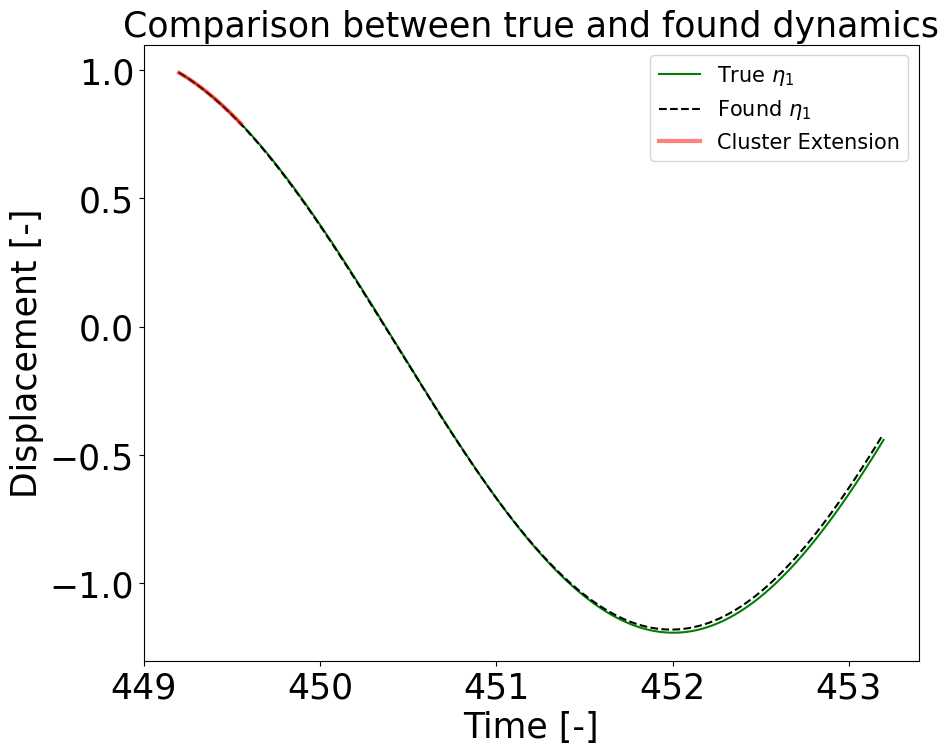

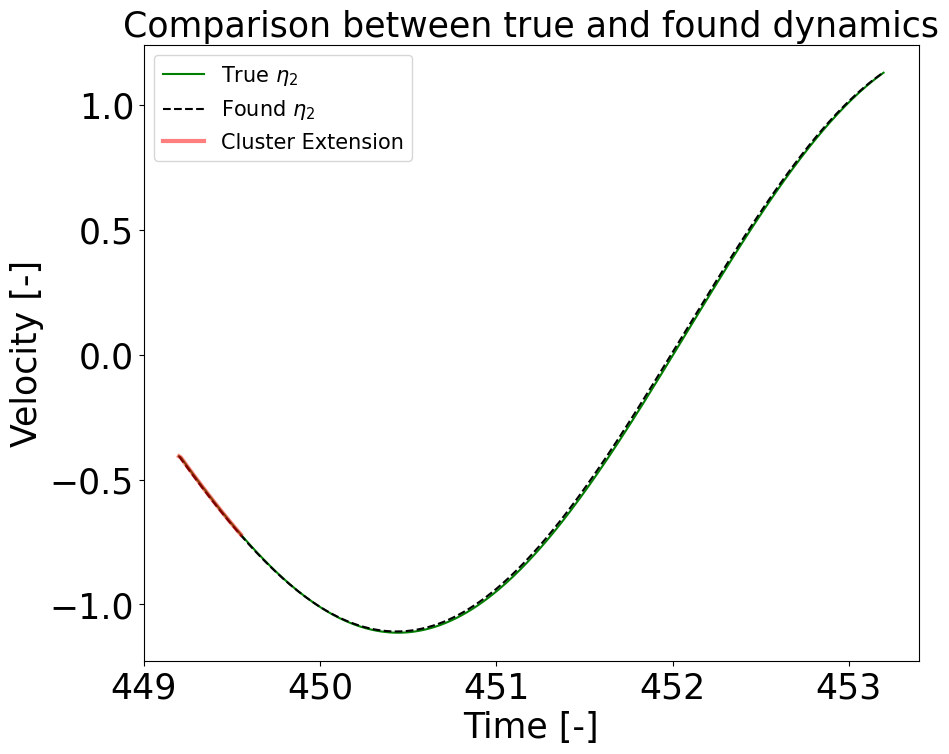

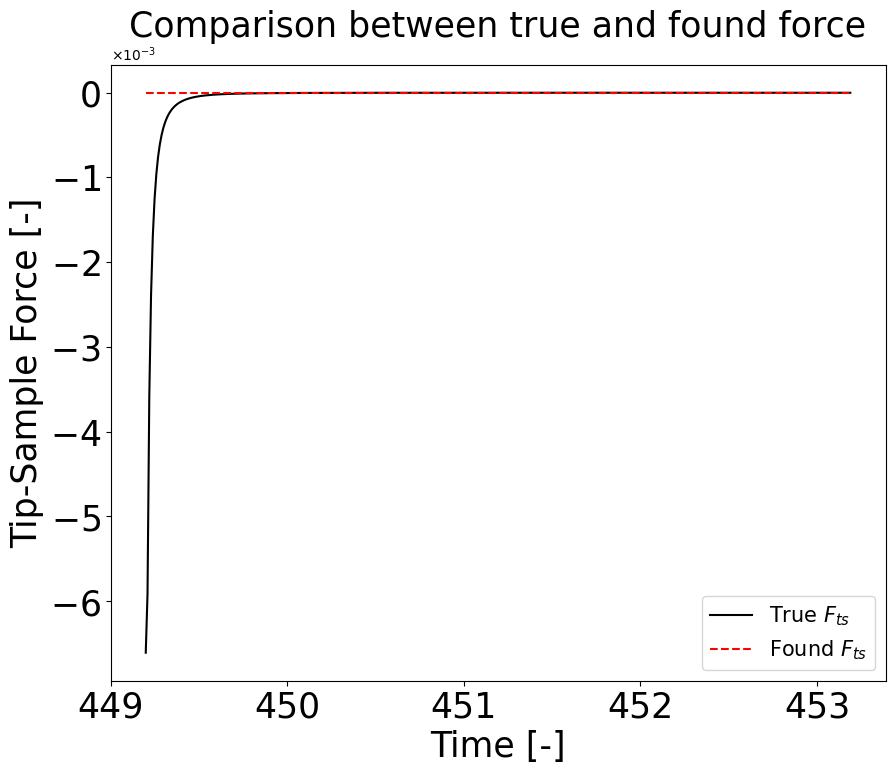

In [50]:
model_to_study = best_rel_AIC_c_C7_df['Candidate Model'][2] 
cluster_to_test = 7                                     

simulated_data_C7, extended_val_trajec_C7, F_ts_true_C7, F_ts_sim_C7 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2, 
                                                 plot = True)

## Analysis for Cluster No. 8

In [51]:
found_models_C8_df = mark_unique_models_in_dataframe(found_models_C8_df)

# Now filter unique models
unique_models_C8_df = found_models_C8_df[found_models_C8_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C8_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 68 unique models were found



## AIC analysis for all models within one cluster: Cluster 8

In [52]:
unique_models_to_analyze = unique_models_C8_df
analyzed_cluster = 8

simulated_information_C8, error_information_C8, AIC_models_in_cluster_C8 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Normal DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2)

rel_AIC_c_lst_C8 = get_relative_AIC_c_score(AIC_models_in_cluster_C8)

unique_models_C8_df['Delta_AIC_c'] = rel_AIC_c_lst_C8

Processing models: 100%|██████████| 68/68 [00:11<00:00,  5.84model/s]


## Best models within Cluster 8

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [53]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C8_df = unique_models_C8_df[unique_models_C8_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C8_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                  Lambda  \
0  25-01-25-036-8           8         3  0.00035938136638046257   
1  25-01-25-073-8           8         4   7.742636826811278e-07   
2  25-01-25-026-8           8         5   2.782559402207126e-07   
3  25-01-25-069-8           8         4  2.1544346900318822e-06   
4  25-01-25-074-8           8         4   7.742636826811278e-07   
5  25-01-25-075-8           8         4   7.742636826811278e-07   

                     Nu  Delta_AIC_c  
0   0.05994842503189409     0.000000  
1  0.046415888336127774     0.004486  
2   0.05994842503189409     0.722106  
3   0.03593813663804628     0.014446  
4                   0.1     0.000631  
5    0.0774263682681127     0.012879

## Simulation of one of these candidate models for cluster 8

rms was: 0.00023060536428608848
switch_ind was: 400

Equation with length: 3
(e1)' = 1.000000000 e2
(e2)' = -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase)
(phase)' = 1.000000000 1



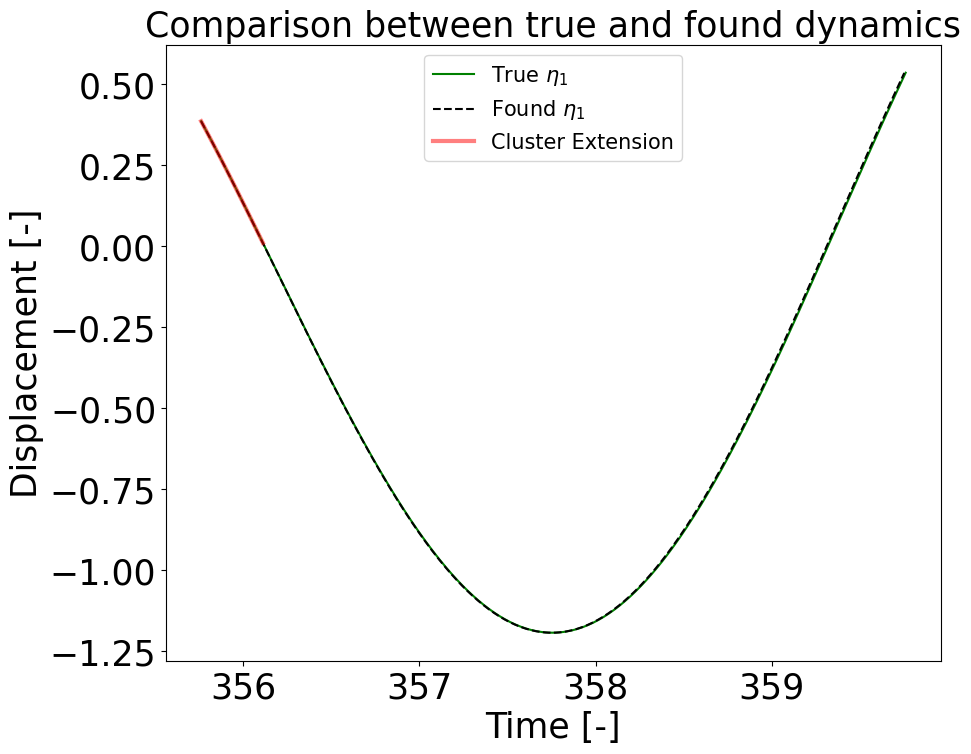

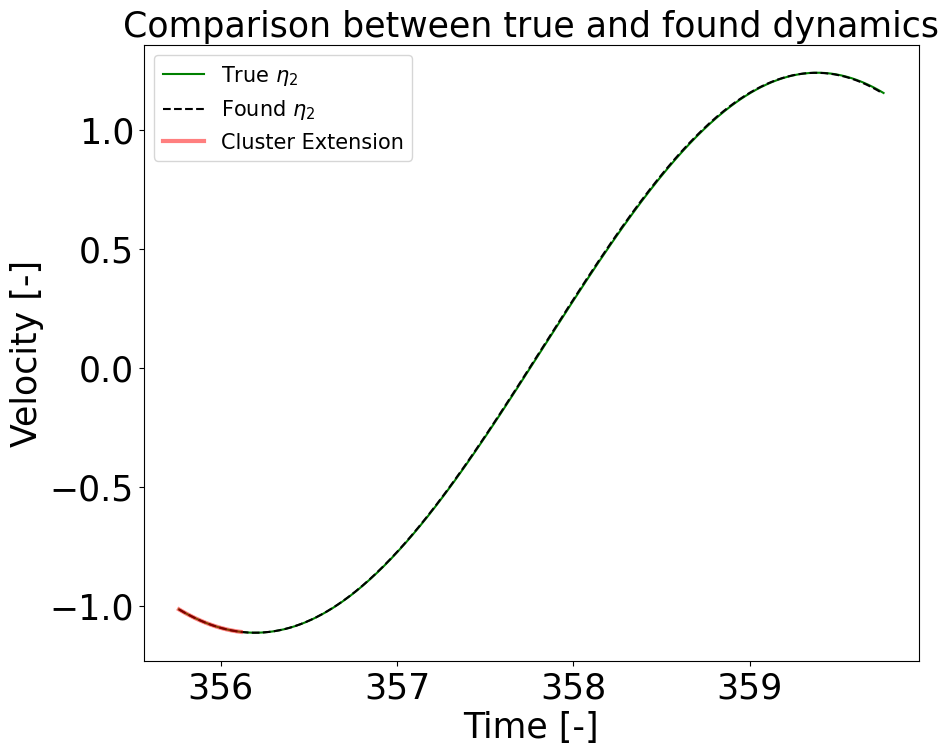

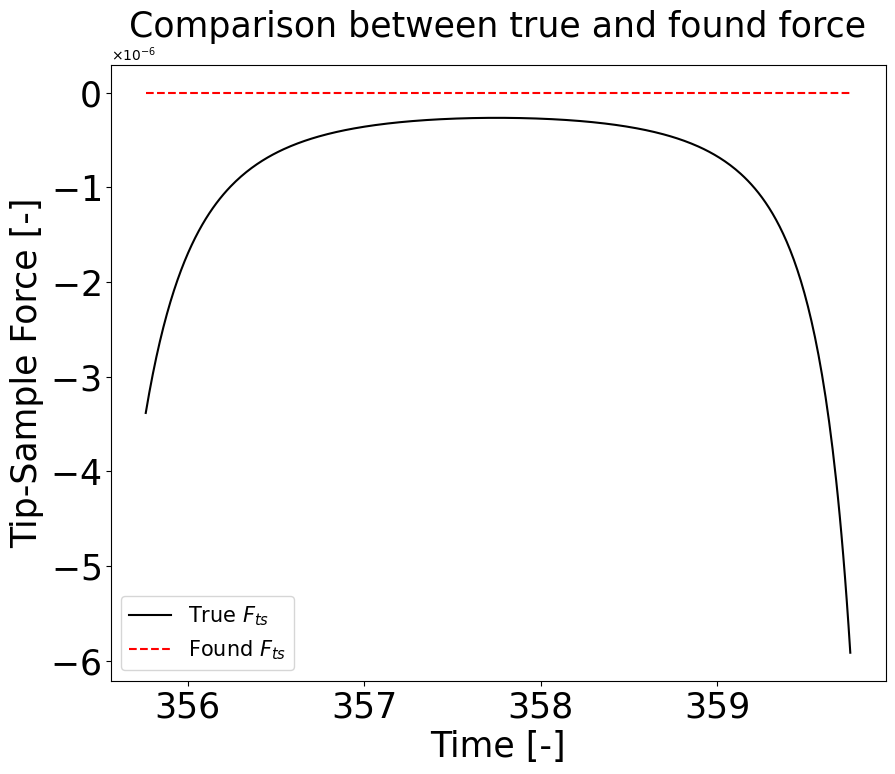

In [54]:
model_to_study = best_rel_AIC_c_C8_df['Candidate Model'][0] #10
cluster_to_test = 8

simulated_data_C8, extended_val_trajec_C8, F_ts_true_C8, F_ts_sim_C8 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2, #'BDF'
                                                 plot = True)

## Analysis for Cluster No. 9

In [55]:
found_models_C9_df = mark_unique_models_in_dataframe(found_models_C9_df)

# Now filter unique models
unique_models_C9_df = found_models_C9_df[found_models_C9_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C9_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



## AIC analysis for all models within one cluster: Cluster 9

In [56]:
unique_models_to_analyze = unique_models_C9_df
analyzed_cluster = 9

simulated_information_C9, error_information_C9, AIC_models_in_cluster_C9 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Normal DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2)

rel_AIC_c_lst_C9 = get_relative_AIC_c_score(AIC_models_in_cluster_C9)

unique_models_C9_df['Delta_AIC_c'] = rel_AIC_c_lst_C9

Processing models: 100%|██████████| 100/100 [00:24<00:00,  4.00model/s]


## Best models within Cluster 9

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [ ]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C9_df = unique_models_C9_df[unique_models_C9_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C9_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                  Lambda  \
0  25-01-25-045-9           9         6  1.6681005372000593e-05   

                   Nu  Delta_AIC_c  
0  0.0774263682681127          0.0

## Simulation of one of these candidate models for cluster 9

rms was: 0.4030723517171723
switch_ind was: 240

Equation with length: 6
(e1)' = 1.000000000 e2
(e2)' = 0.000022392 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + 0.001489049 (1-e1)^-2 + -0.002621579 (1-e1)^-3
(phase)' = 1.000000000 1



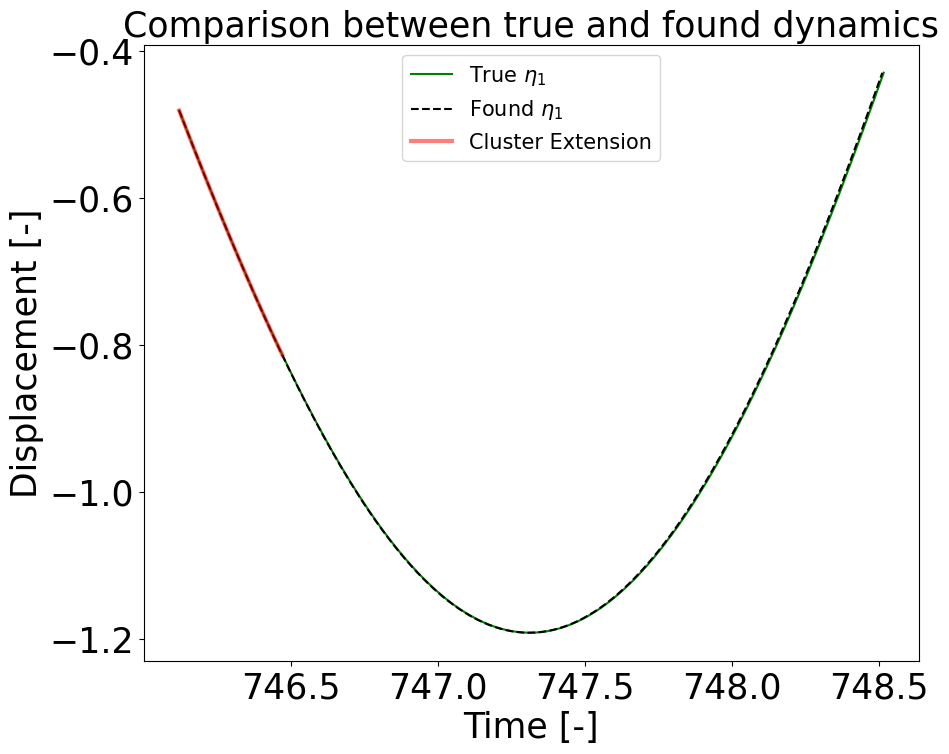

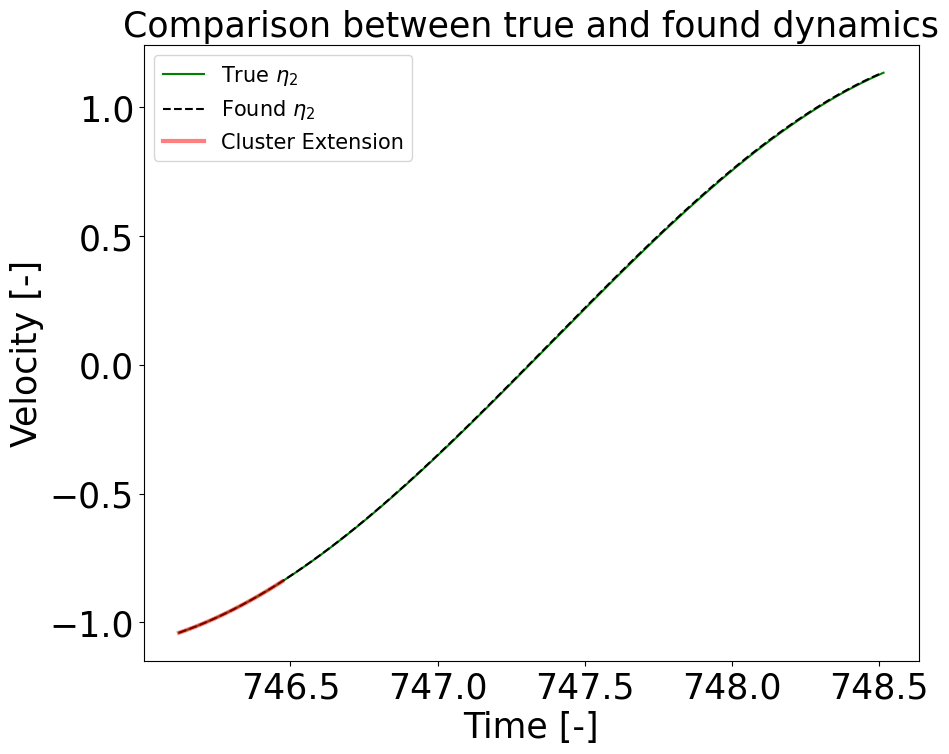

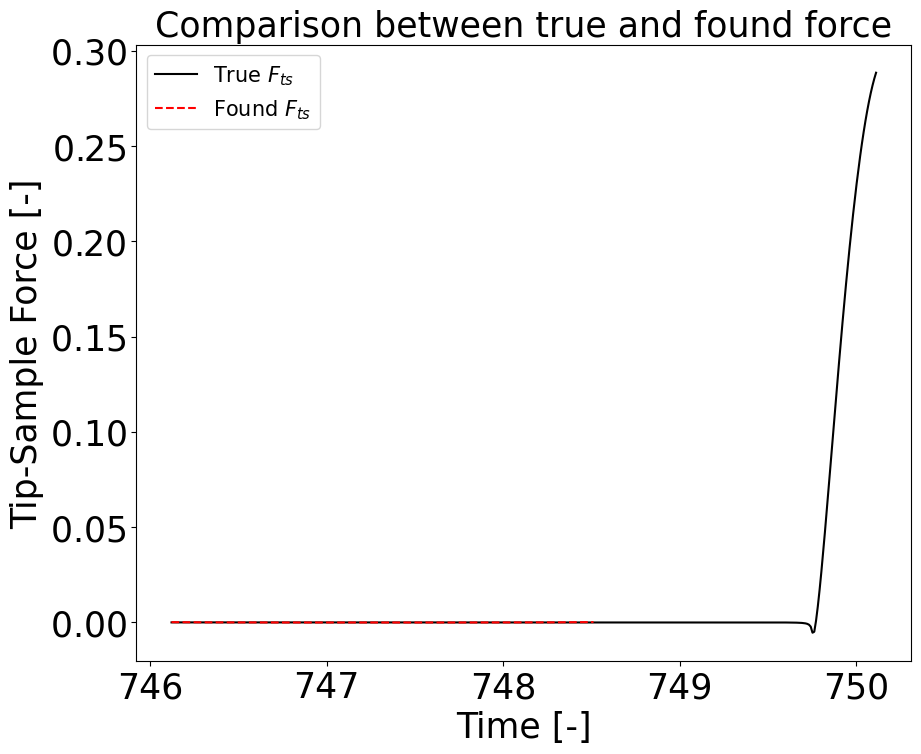

In [58]:
model_to_study = best_rel_AIC_c_C9_df['Candidate Model'][0] 
cluster_to_test = 9

simulated_data_C9, extended_val_trajec_C9, F_ts_true_C9, F_ts_sim_C9 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-4,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2,
                                                 plot = True)

## Analysis for Cluster No. 10

In [59]:
found_models_C10_df = mark_unique_models_in_dataframe(found_models_C10_df)

# Now filter unique models
unique_models_C10_df = found_models_C10_df[found_models_C10_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C10_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



## AIC analysis for all models within one cluster: Cluster 10

In [60]:
unique_models_to_analyze = unique_models_C10_df
analyzed_cluster = 10

simulated_information_C10, error_information_C10, AIC_models_in_cluster_C10 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Normal DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2)

rel_AIC_c_lst_C10 = get_relative_AIC_c_score(AIC_models_in_cluster_C10)

unique_models_C10_df['Delta_AIC_c'] = rel_AIC_c_lst_C10

Processing models: 100%|██████████| 100/100 [00:29<00:00,  3.44model/s]


## Best models within Cluster 10

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [ ]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C10_df = unique_models_C10_df[unique_models_C10_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C10_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                 Lambda   Nu  \
0  25-01-25-054-10          10         6  5.994842503189409e-06  0.1   

   Delta_AIC_c  
0          0.0

## Simulation of one of these candidate models for cluster 10

rms was: 5.347719232614322
switch_ind was: 252

Equation with length: 6
(e1)' = 1.000000000 e2
(e2)' = -0.000078294 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + -0.022938704 (1-e1)^-2 + 0.029512384 (1-e1)^-3
(phase)' = 1.000000000 1



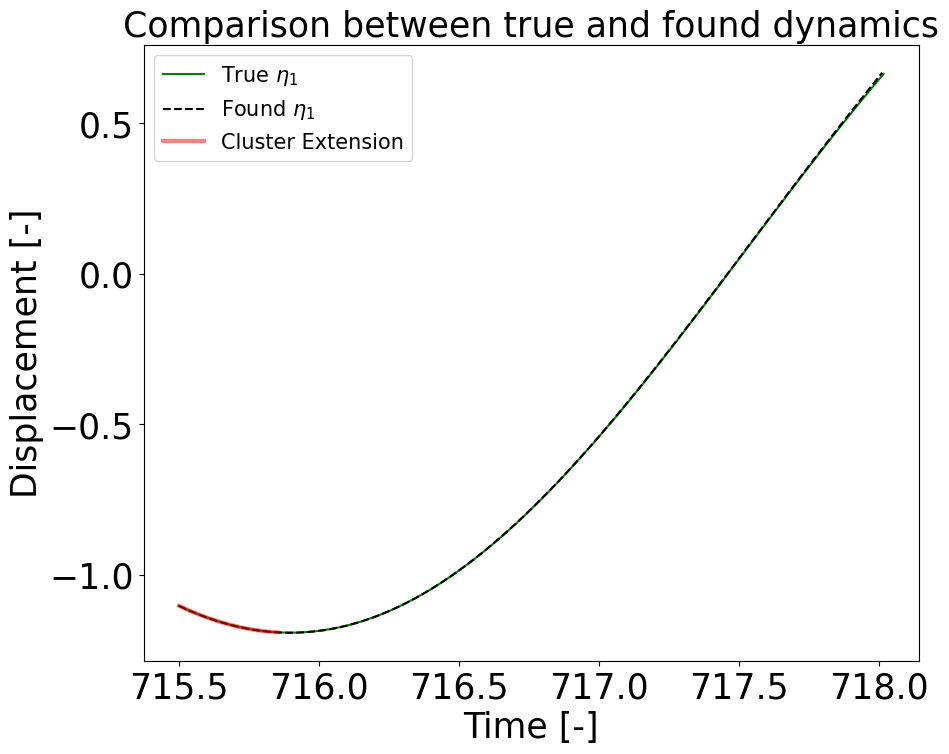

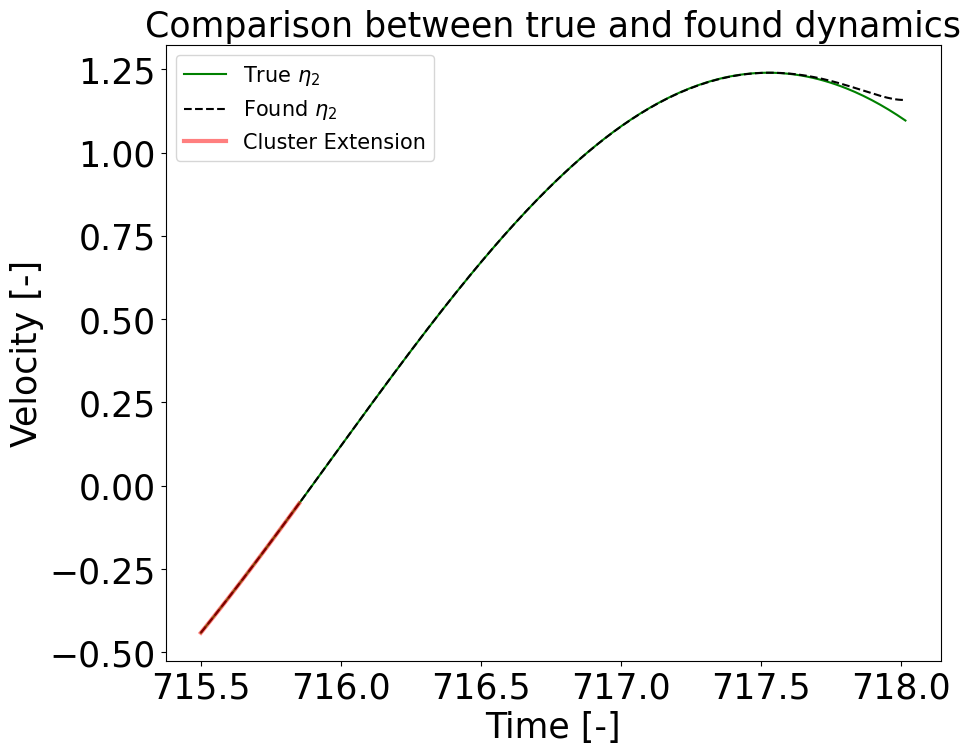

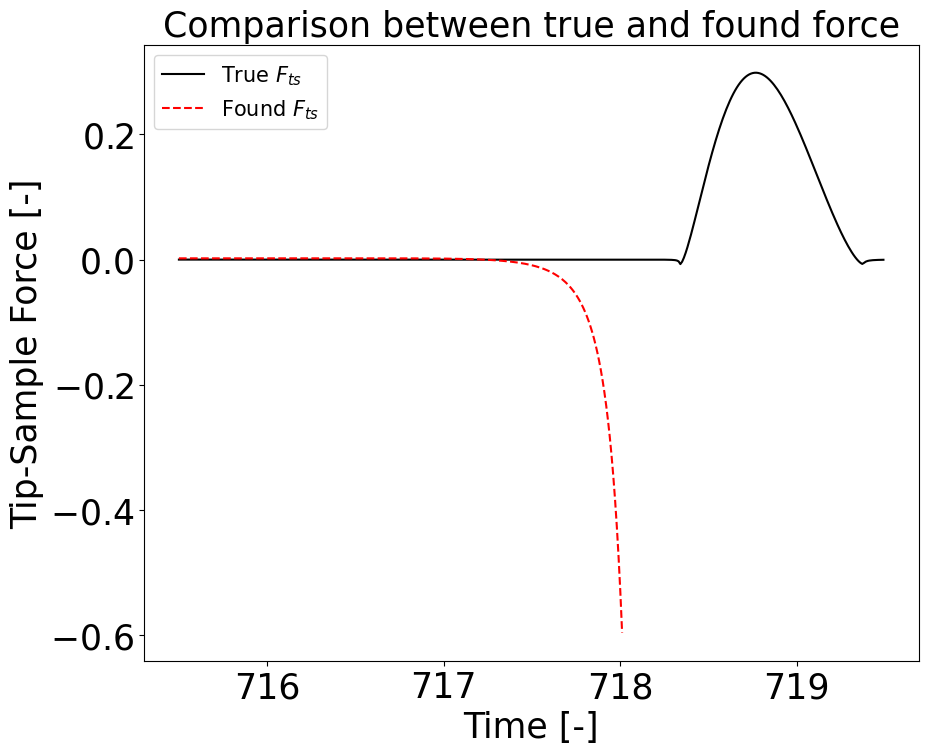

In [62]:
model_to_study = best_rel_AIC_c_C10_df['Candidate Model'][0] 
cluster_to_test = 10

simulated_data_C10, extended_val_trajec_C10, F_ts_true_C10, F_ts_sim_C10 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2, 
                                                 plot = True)

## Analysis for Cluster No. 11

In [63]:
found_models_C11_df = mark_unique_models_in_dataframe(found_models_C11_df)

# Now filter unique models
unique_models_C11_df = found_models_C11_df[found_models_C11_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C11_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



## AIC analysis for all models within one cluster: Cluster 11

In [64]:
unique_models_to_analyze = unique_models_C11_df
analyzed_cluster = 11

simulated_information_C11, error_information_C11, AIC_models_in_cluster_C11 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Normal DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2)

rel_AIC_c_lst_C11 = get_relative_AIC_c_score(AIC_models_in_cluster_C11)

unique_models_C11_df['Delta_AIC_c'] = rel_AIC_c_lst_C11

Processing models: 100%|██████████| 100/100 [00:29<00:00,  3.40model/s]


## Best models within Cluster 11

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [ ]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C11_df = unique_models_C11_df[unique_models_C11_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C11_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                  Lambda  \
0  26-01-25-034-11          11         5  0.00035938136638046257   
1  26-01-25-077-11          11         6   7.742636826811278e-07   

                     Nu  Delta_AIC_c  
0                   0.1     0.643416  
1  0.027825594022071243     0.000000

## Simulation of one of these candidate models for cluster 11

rms was: 0.9093856713909545
switch_ind was: 200

Equation with length: 5
(e1)' = 1.000000000 e2
(e2)' = 0.000315651 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + 0.001071014 (1-e1)^-3
(phase)' = 1.000000000 1



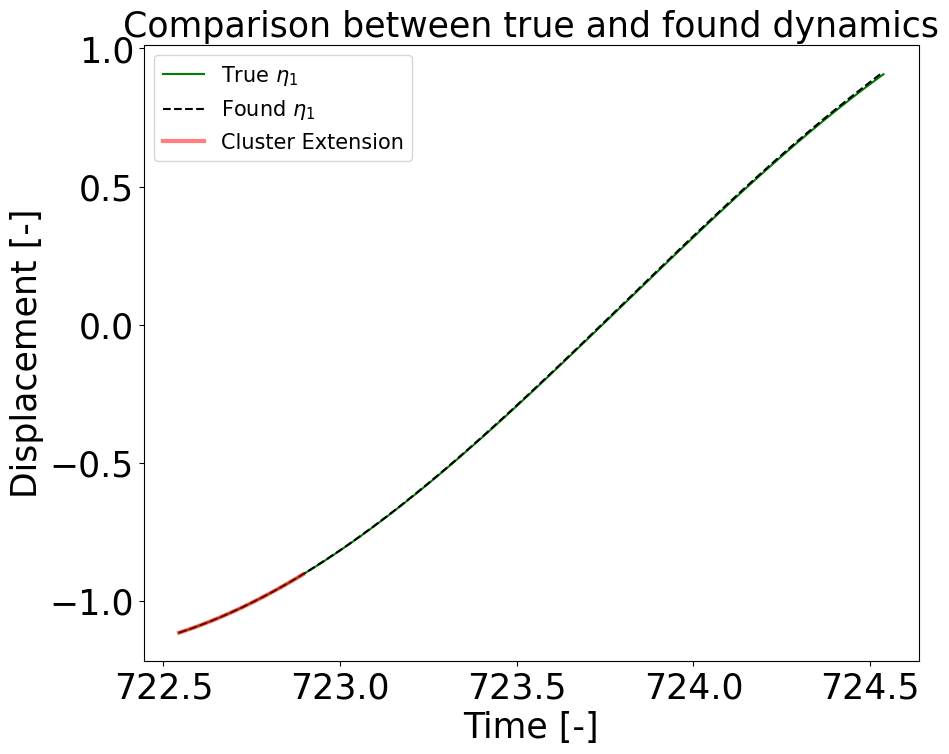

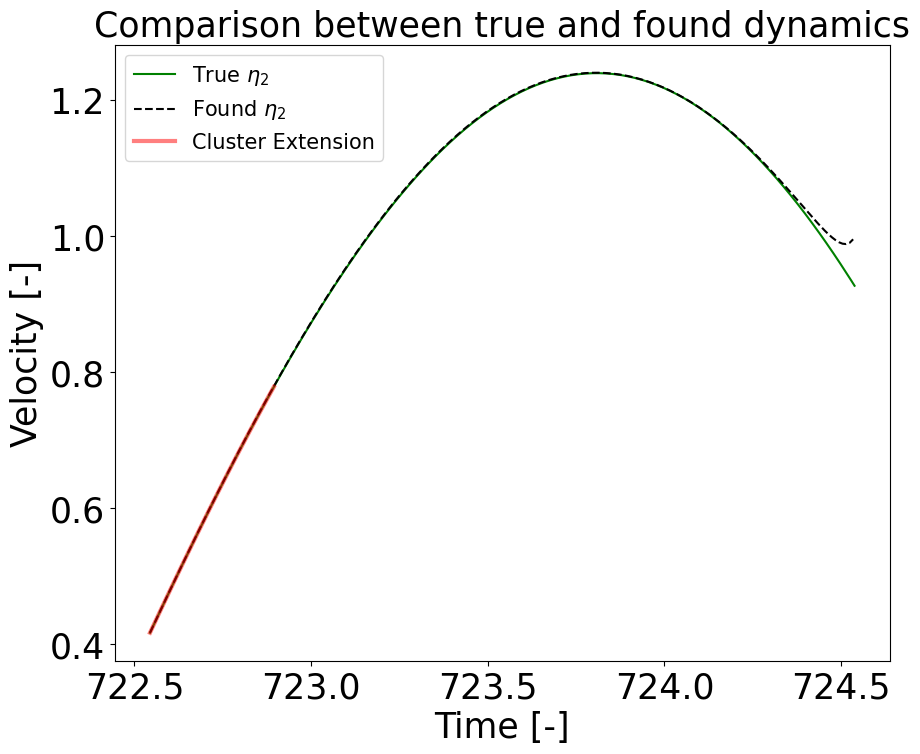

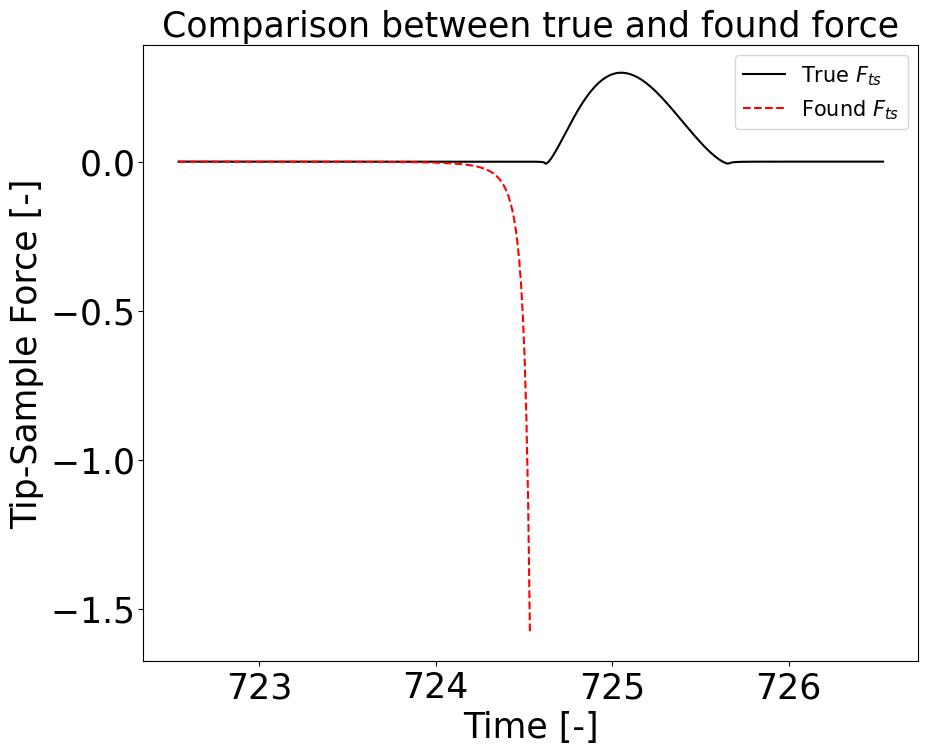

In [66]:
model_to_study = best_rel_AIC_c_C11_df['Candidate Model'][0] 
cluster_to_test = 11

simulated_data_C11, extended_val_trajec_C11, F_ts_true_C11, F_ts_sim_C11 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2,
                                                 plot = True)

## Analysis for Cluster No. 12

In [67]:
found_models_C12_df = mark_unique_models_in_dataframe(found_models_C12_df)

# Now filter unique models
unique_models_C12_df = found_models_C12_df[found_models_C12_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C12_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



## AIC analysis for all models within one cluster: Cluster 12

In [68]:
unique_models_to_analyze = unique_models_C12_df
analyzed_cluster = 12

simulated_information_C12, error_information_C12, AIC_models_in_cluster_C12 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-2, model_type = 'Normal DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2)

rel_AIC_c_lst_C12 = get_relative_AIC_c_score(AIC_models_in_cluster_C12)

unique_models_C12_df['Delta_AIC_c'] = rel_AIC_c_lst_C12

Processing models: 100%|██████████| 100/100 [00:37<00:00,  2.68model/s]


## Best models within Cluster 12

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [69]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C12_df = unique_models_C12_df[unique_models_C12_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C12_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony Lambda                   Nu  \
0  26-01-25-006-12          12         7  0.001  0.05994842503189409   

   Delta_AIC_c  
0          0.0

## Simulation of one of these candidate models for cluster 12

rms was: 0.8745619273850187
switch_ind was: 3

Equation with length: 7
(e1)' = 1.000000000 e2
(e2)' = -0.665235470 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + -482.283427033 (0.0132626-1+e1)^1.5 + 906.373599040 (0.0132626-1+e1)^2 + 219.349042835 (0.0132626-1+e1)^2.5
(phase)' = 1.000000000 1



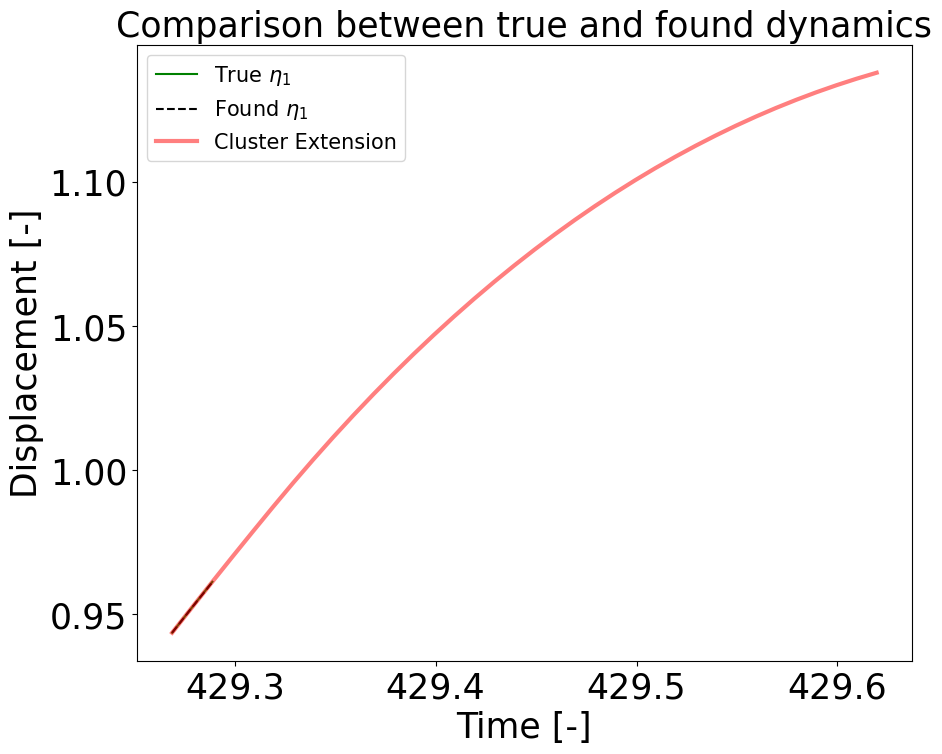

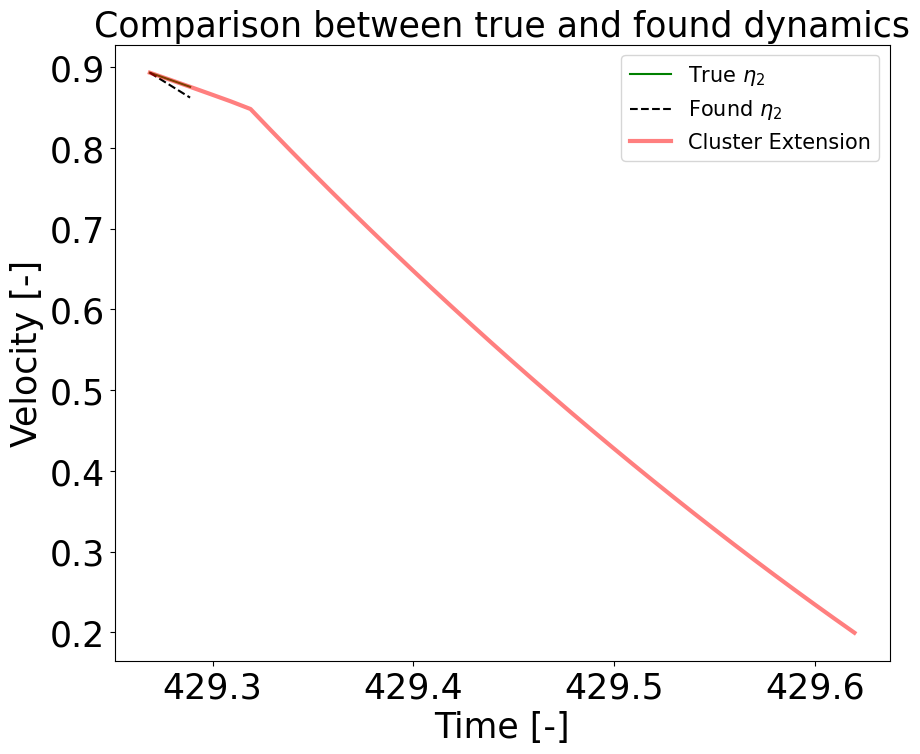

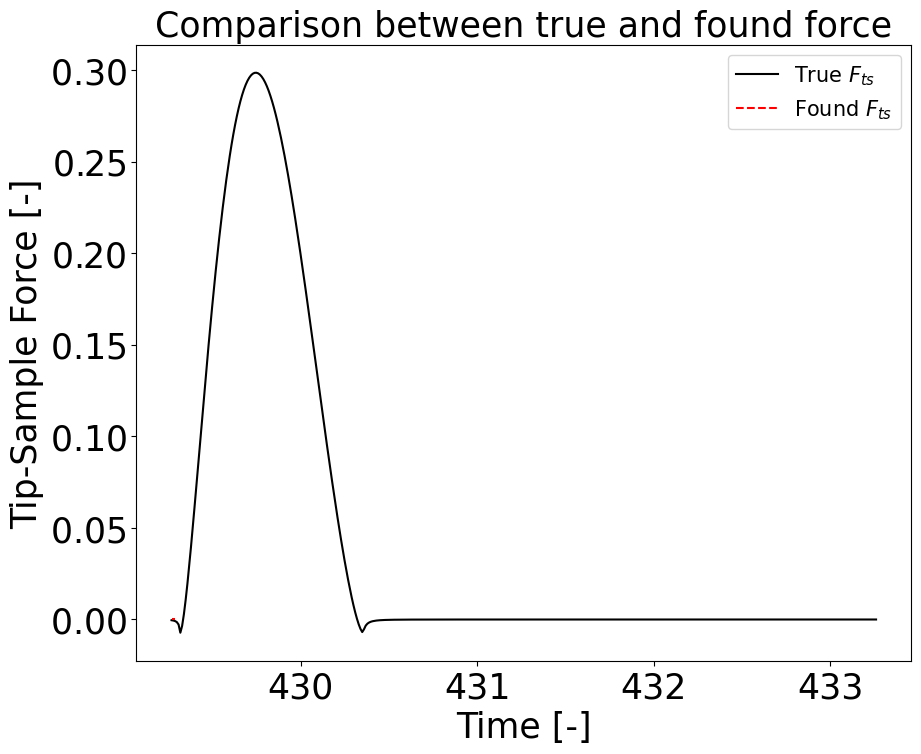

In [70]:
model_to_study = best_rel_AIC_c_C12_df['Candidate Model'][0] #10
cluster_to_test = 12

simulated_data_C12, extended_val_trajec_C12, F_ts_true_C12, F_ts_sim_C12 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2, #'BDF'
                                                 plot = True)

## Analysis for Cluster No. 13

In [71]:
found_models_C13_df = mark_unique_models_in_dataframe(found_models_C13_df)

# Now filter unique models
unique_models_C13_df = found_models_C13_df[found_models_C13_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C13_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



## AIC analysis for all models within one cluster: Cluster 13

In [72]:
unique_models_to_analyze = unique_models_C13_df
analyzed_cluster = 13

simulated_information_C13, error_information_C13, AIC_models_in_cluster_C13 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Normal DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2)

rel_AIC_c_lst_C13 = get_relative_AIC_c_score(AIC_models_in_cluster_C13)

unique_models_C13_df['Delta_AIC_c'] = rel_AIC_c_lst_C13

Processing models: 100%|██████████| 100/100 [00:18<00:00,  5.48model/s]


## Best models within Cluster 13

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [73]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C13_df = unique_models_C13_df[unique_models_C13_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C13_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony Lambda                    Nu  \
0  26-01-25-001-13          13         7  0.001  0.016681005372000592   
1  26-01-25-002-13          13         6  0.001   0.01291549665014884   

   Delta_AIC_c  
0     0.966294  
1     0.000000

## Simulation of one of these candidate models for cluster 13

rms was: 0.48427272516337977
switch_ind was: 15

Equation with length: 7
(e1)' = 1.000000000 e2
(e2)' = 0.771839885 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + -2.508839571 (0.0132626-1+e1)^1.5 + -19.175841993 (0.0132626-1+e1)^2 + 15.854647441 (0.0132626-1+e1)^2.5
(phase)' = 1.000000000 1



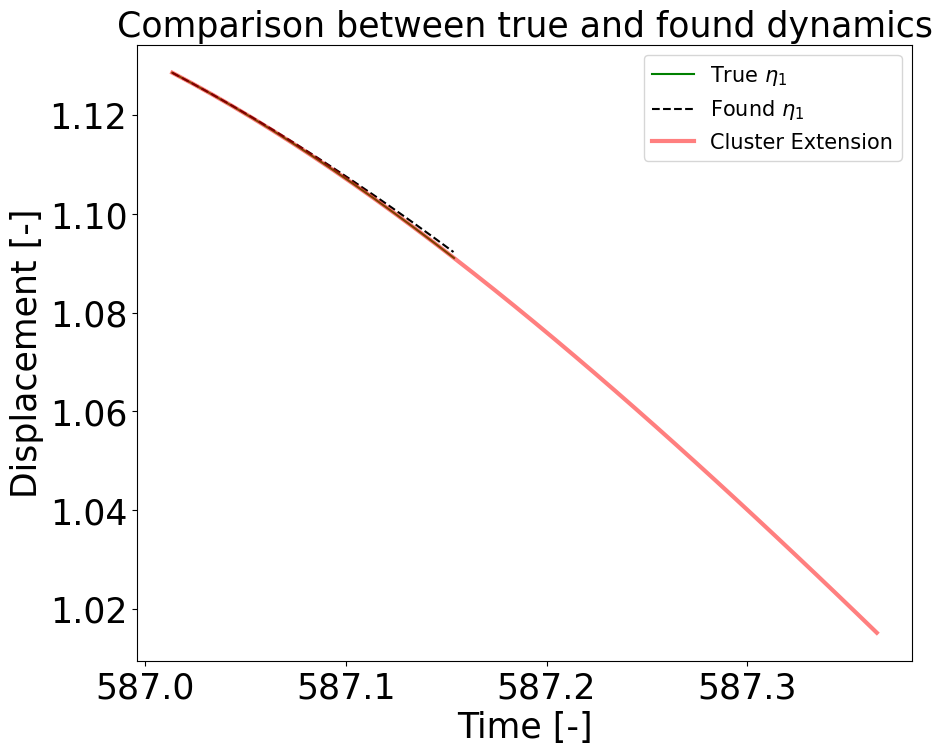

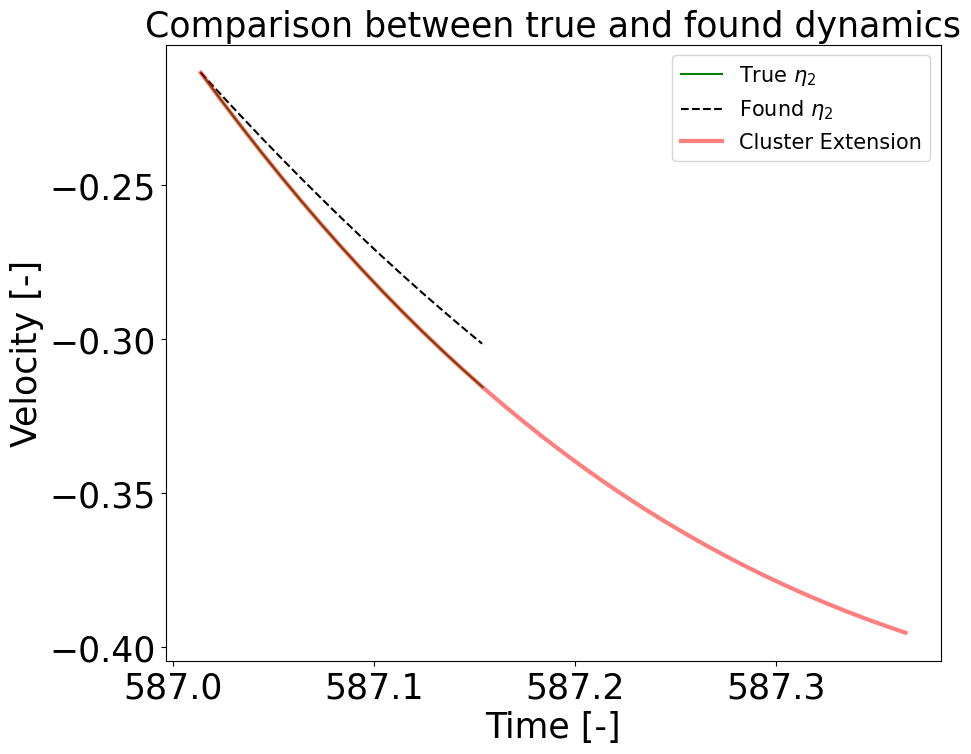

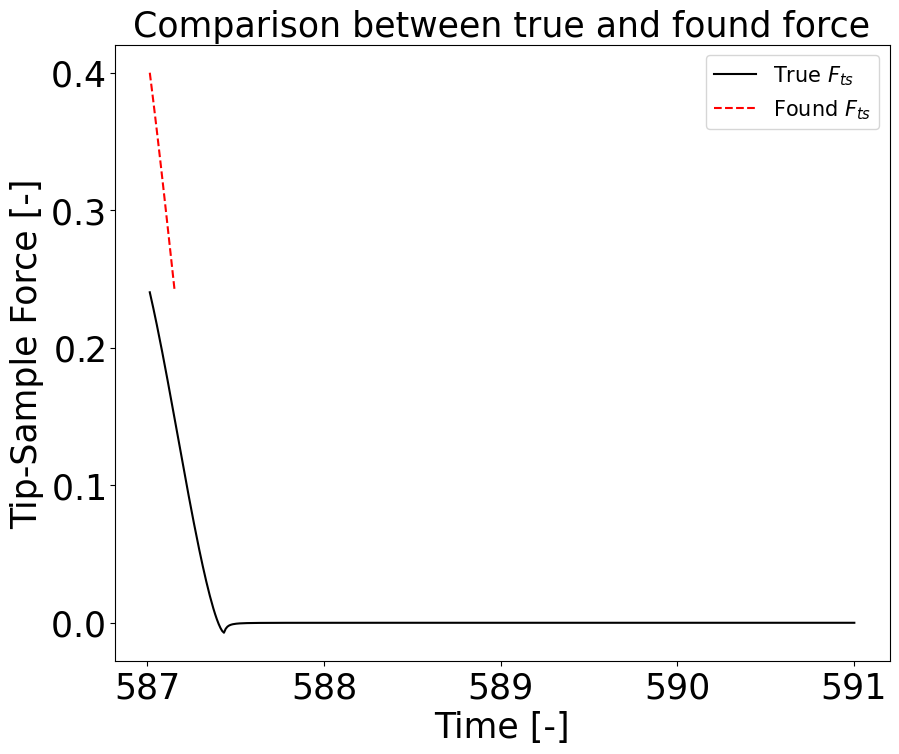

In [ ]:
model_to_study = best_rel_AIC_c_C13_df['Candidate Model'][0] 
cluster_to_test = 13

simulated_data_C13, extended_val_trajec_C13, F_ts_true_C13, F_ts_sim_C13 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2, #'BDF'
                                                 plot = True)

## Analysis for Cluster No. 14

In [75]:
found_models_C14_df = mark_unique_models_in_dataframe(found_models_C14_df)

# Now filter unique models
unique_models_C14_df = found_models_C14_df[found_models_C14_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C14_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 47 unique models were found



## AIC analysis for all models within one cluster: Cluster 14

In [76]:
unique_models_to_analyze = unique_models_C14_df
analyzed_cluster = 14

simulated_information_C14, error_information_C14, AIC_models_in_cluster_C14 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Normal DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2)

rel_AIC_c_lst_C14 = get_relative_AIC_c_score(AIC_models_in_cluster_C14)

unique_models_C14_df['Delta_AIC_c'] = rel_AIC_c_lst_C14

Processing models: 100%|██████████| 47/47 [00:07<00:00,  6.09model/s]


## Best models within Cluster 14

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [77]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C14_df = unique_models_C14_df[unique_models_C14_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C14_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                  Lambda  \
0   26-01-25-072-14          14         6   7.742636826811278e-07   
1   26-01-25-003-14          14         3                   0.001   
2   26-01-25-079-14          14         4   7.742636826811278e-07   
3   26-01-25-070-14          14         4   7.742636826811278e-07   
4   26-01-25-051-14          14         4   5.994842503189409e-06   
5   26-01-25-077-14          14         4   7.742636826811278e-07   
6   26-01-25-071-14          14         4   7.742636826811278e-07   
7   26-01-25-053-14          14         4   5.994842503189409e-06   
8   26-01-25-065-14          14         4  2.1544346900318822e-06   
9   26-01-25-060-14          14         4  2.1544346900318822e-06   
10  26-01-25-059-14          14         4   5.994842503189409e-06   

                      Nu  Delta_AIC_c  
0    0.01291549665014884     0.000000  
1   0.046415888336127774     0.658375  
2    0.03593813663804628     0.650060  
3                   0.01     0.655178  
4   0.016681005372000592     0.660818  
5   0.027825594022071243     0.668733  
6   0.016681005372000592     0.669869  
7   0.046415888336127774     0.660631  
8     0.0774263682681127     0.661231  
9                   0.01     0.663070  
10   0.03593813663804628     0.675199

## Simulation of one of these candidate models for cluster 14

rms was: 0.0002683789810121908
switch_ind was: 400

Equation with length: 6
(e1)' = 1.000000000 e2
(e2)' = 0.000004200 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + 0.000003439 (1-e1)^-2 + -0.000000703 (1-e1)^-3
(phase)' = 1.000000000 1



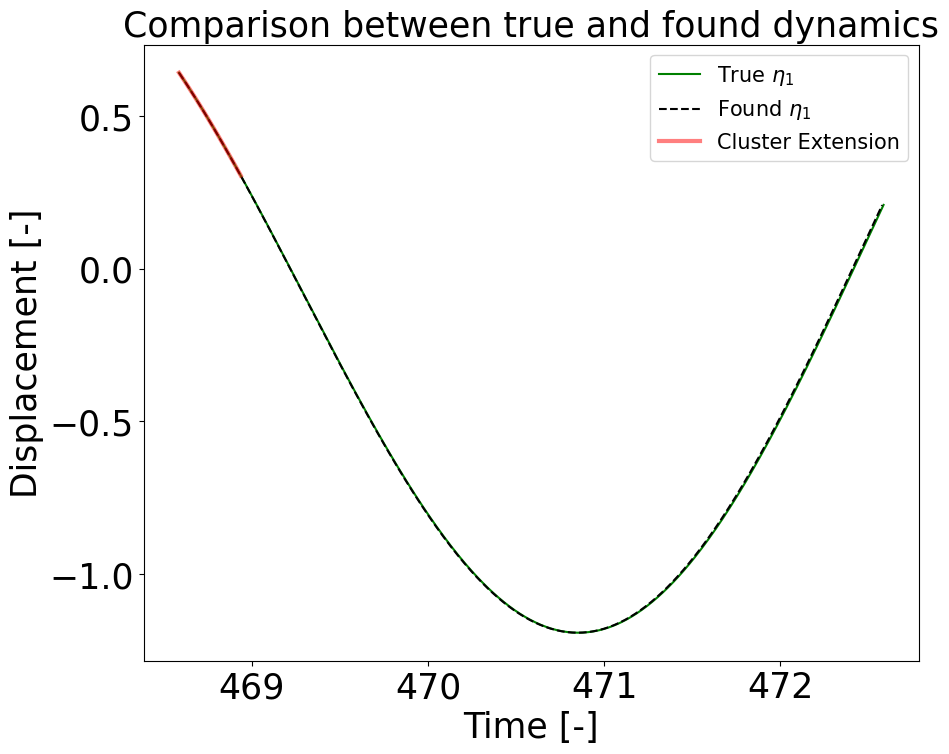

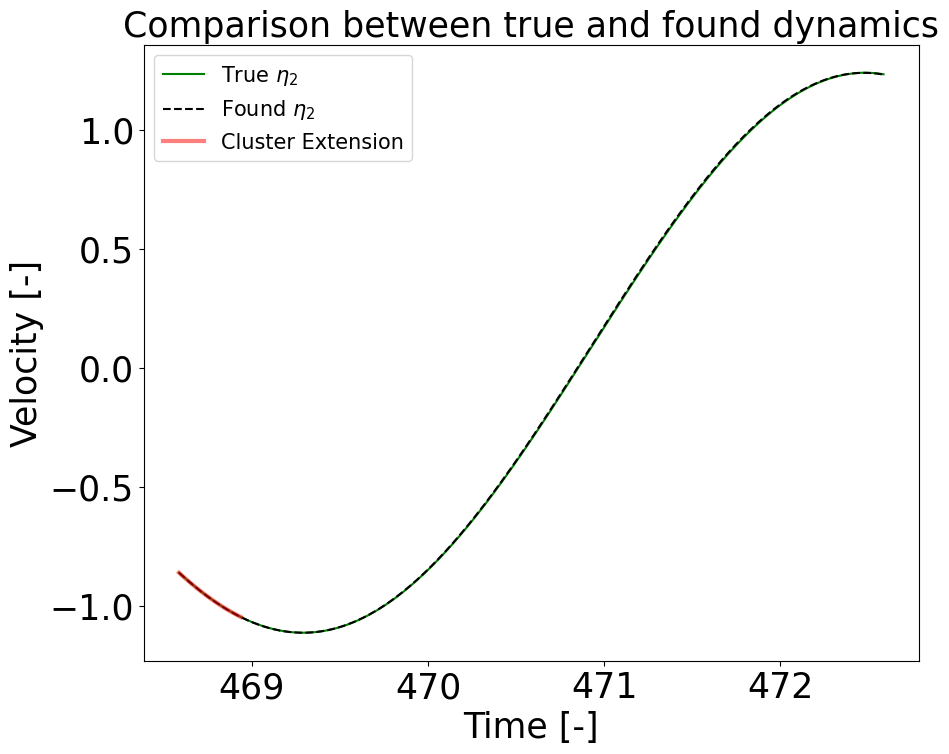

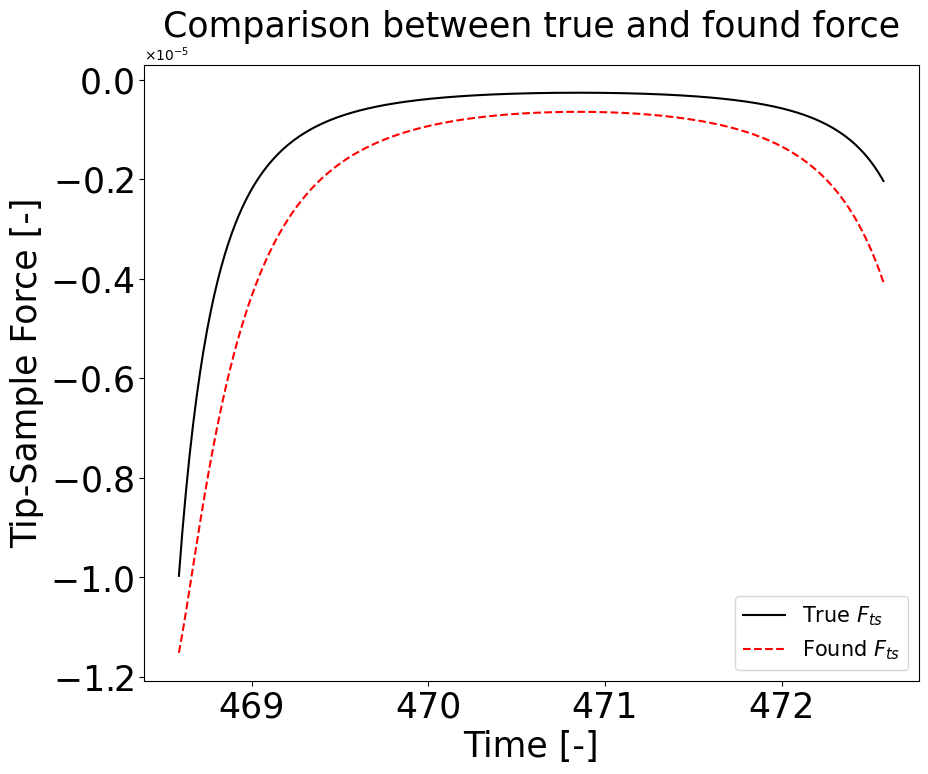

In [78]:
model_to_study = best_rel_AIC_c_C14_df['Candidate Model'][0] 
cluster_to_test = 14

simulated_data_C14, extended_val_trajec_C14, F_ts_true_C14, F_ts_sim_C14 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2,
                                                 plot = True)

## Analysis for Cluster No. 15

In [79]:
found_models_C15_df = mark_unique_models_in_dataframe(found_models_C15_df)

# Now filter unique models
unique_models_C15_df = found_models_C15_df[found_models_C15_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C15_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 98 unique models were found



## AIC analysis for all models within one cluster: Cluster 15

In [80]:
unique_models_to_analyze = unique_models_C15_df
analyzed_cluster = 15

simulated_information_C15, error_information_C15, AIC_models_in_cluster_C15 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Normal DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2)

rel_AIC_c_lst_C15 = get_relative_AIC_c_score(AIC_models_in_cluster_C15)

unique_models_C15_df['Delta_AIC_c'] = rel_AIC_c_lst_C15

Processing models: 100%|██████████| 98/98 [00:20<00:00,  4.83model/s]


## Best models within Cluster 15

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [81]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C15_df = unique_models_C15_df[unique_models_C15_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C15_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony Lambda    Nu  Delta_AIC_c
0  26-01-25-000-15          15         3  0.001  0.01          0.0

## Simulation of one of these candidate models for cluster 15

rms was: 0.012361111303923717
switch_ind was: 398

Equation with length: 3
(e1)' = 1.000000000 e2
(e2)' = -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase)
(phase)' = 1.000000000 1



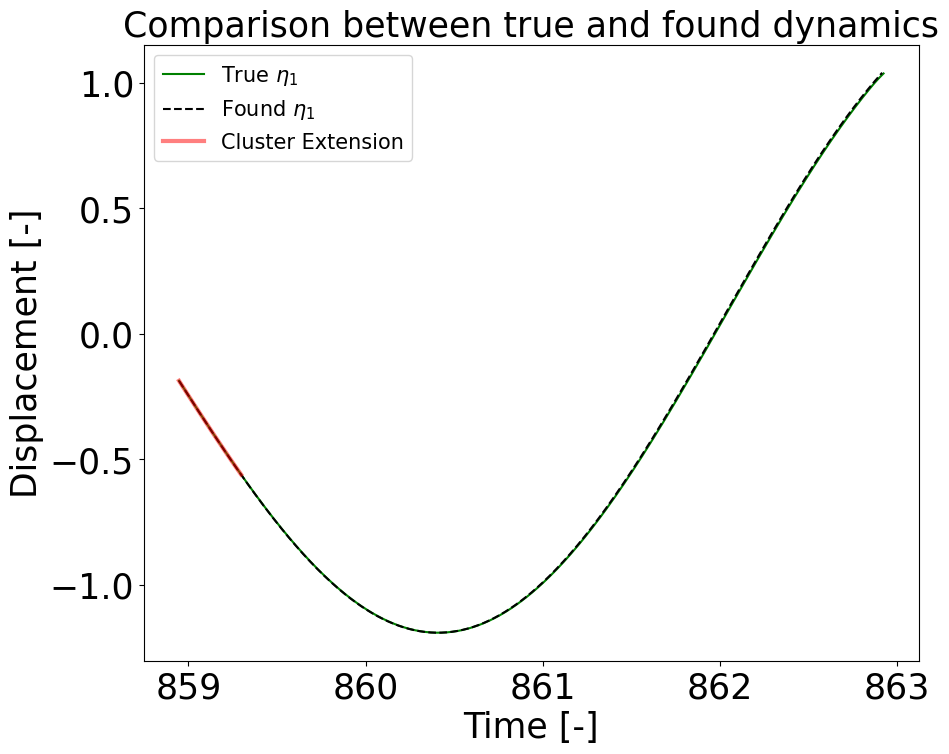

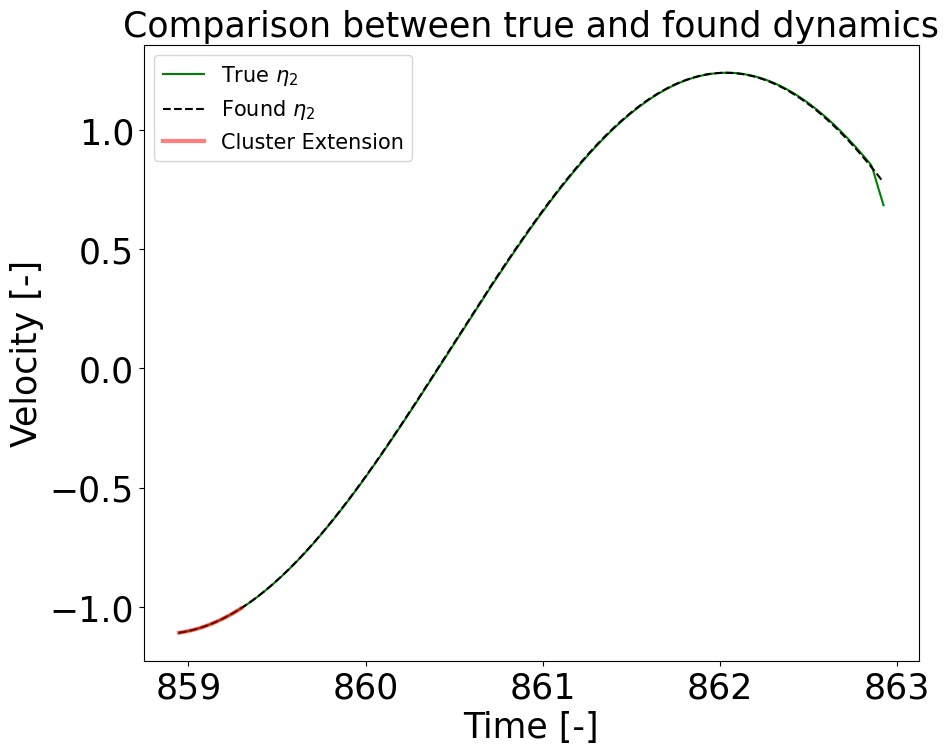

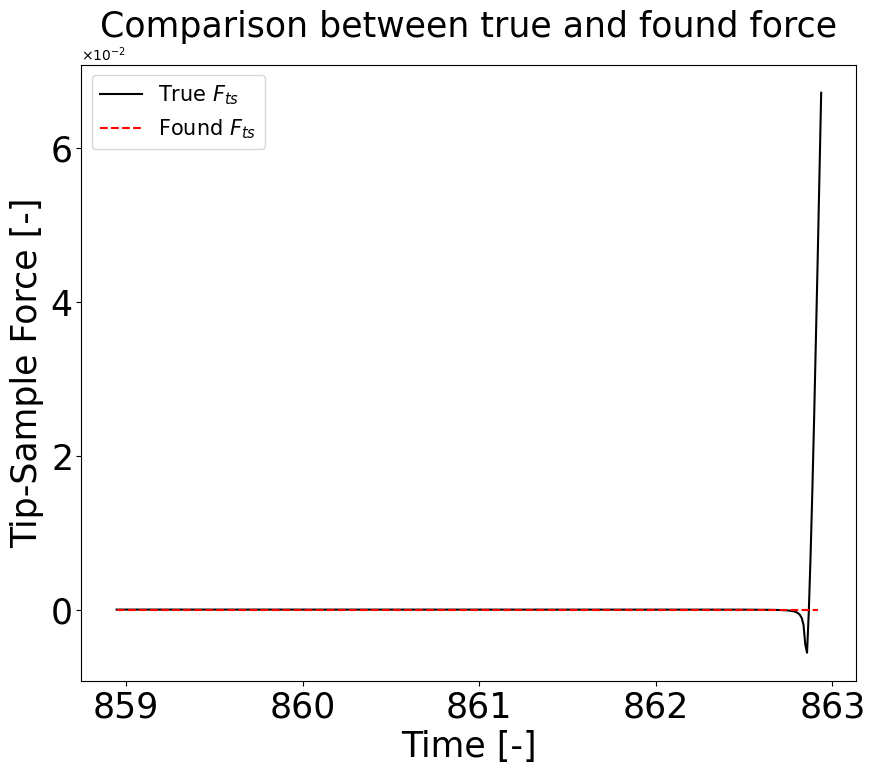

In [82]:
model_to_study = best_rel_AIC_c_C15_df['Candidate Model'][0] #10
cluster_to_test = 15

simulated_data_C15, extended_val_trajec_C15, F_ts_true_C15, F_ts_sim_C15 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2, #'BDF'
                                                 plot = True)

## Analysis for Cluster No. 16

In [83]:
found_models_C16_df = mark_unique_models_in_dataframe(found_models_C16_df)

# Now filter unique models
unique_models_C16_df = found_models_C16_df[found_models_C16_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C16_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



## AIC analysis for all models within one cluster: Cluster 16

In [84]:
unique_models_to_analyze = unique_models_C16_df
analyzed_cluster = 16

simulated_information_C16, error_information_C16, AIC_models_in_cluster_C16 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Normal DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2)

rel_AIC_c_lst_C16 = get_relative_AIC_c_score(AIC_models_in_cluster_C16)

unique_models_C16_df['Delta_AIC_c'] = rel_AIC_c_lst_C16

Processing models: 100%|██████████| 100/100 [00:26<00:00,  3.73model/s]


## Best models within Cluster 16

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [85]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C16_df = unique_models_C16_df[unique_models_C16_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C16_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                  Lambda  \
0  26-01-25-011-16          16         4  0.00012915496650148828   

                     Nu  Delta_AIC_c  
0  0.016681005372000592          0.0

## Simulation of one of these candidate models for cluster 16

rms was: 0.1443087193476855
switch_ind was: 317

Equation with length: 4
(e1)' = 1.000000000 e2
(e2)' = 0.006395549 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase)
(phase)' = 1.000000000 1



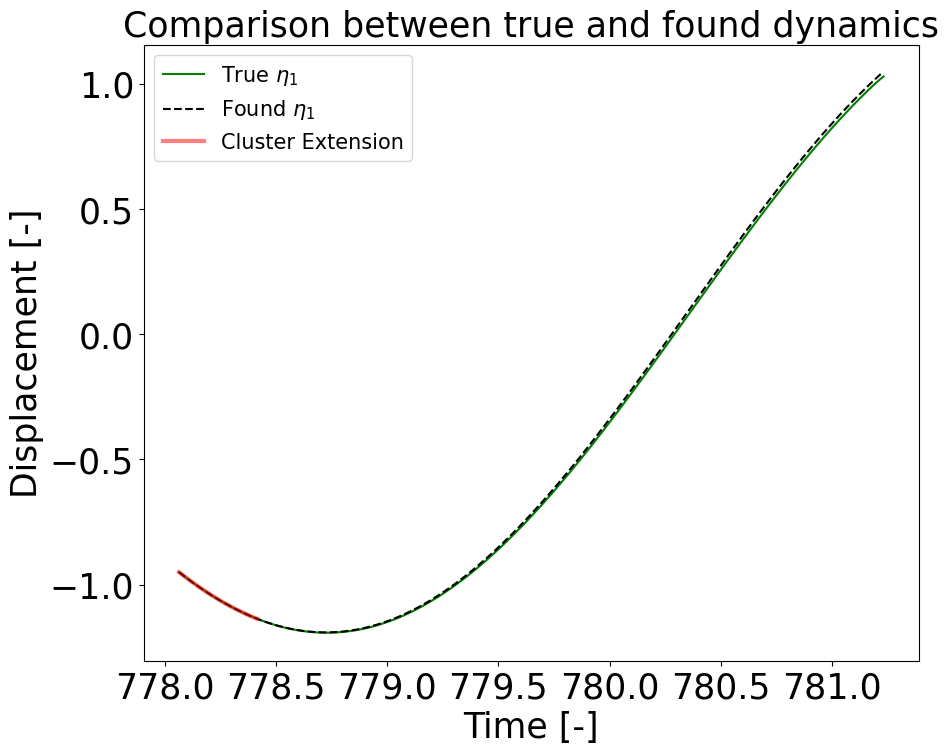

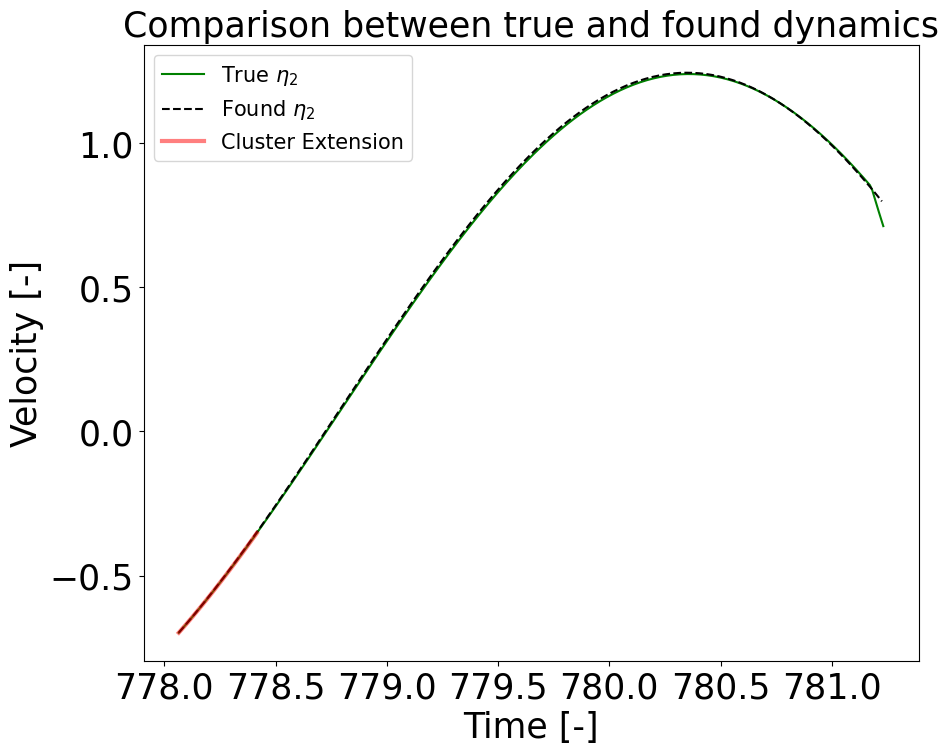

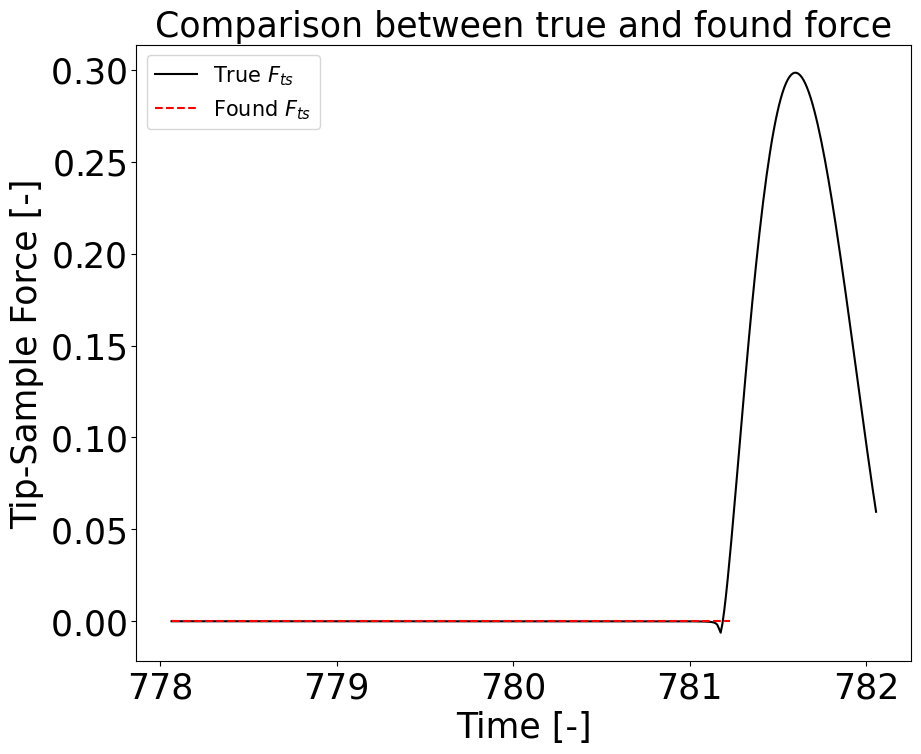

In [86]:
model_to_study = best_rel_AIC_c_C16_df['Candidate Model'][0] #10
cluster_to_test = 16

simulated_data_C16, extended_val_trajec_C16, F_ts_true_C16, F_ts_sim_C16 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2, #'BDF'
                                                 plot = True)

______________________________________________________________________________________________________________________________________________________________

# Analysis of best models across all clusters

The purpose of this section is to analyze all the best models identified by the $\Delta AIC_{c}$ analysis. To achieve this, the algorithm counts the occurrences of these best models while also remembering their respective clusters. 

## Concatenation of best $\Delta AIC_{c}$ models

Here, the code is grouping or concatenating all the previus dataframes containing only those models which scored a $\Delta AIC_{c} < 1$. Therefore, this dataframe contained the library of best scored candidate models for describing the dynamics of the system. 

In [87]:
# List of the DataFrames
dataframes = [
    best_rel_AIC_c_C0_df,
    best_rel_AIC_c_C1_df,
    best_rel_AIC_c_C2_df,
    best_rel_AIC_c_C3_df,
    best_rel_AIC_c_C4_df,
    best_rel_AIC_c_C5_df,
    best_rel_AIC_c_C6_df,
    best_rel_AIC_c_C7_df,
    best_rel_AIC_c_C8_df,
    best_rel_AIC_c_C9_df,
    best_rel_AIC_c_C10_df,
    best_rel_AIC_c_C11_df,
    best_rel_AIC_c_C12_df,
    best_rel_AIC_c_C13_df,
    best_rel_AIC_c_C14_df,
    best_rel_AIC_c_C15_df,
    best_rel_AIC_c_C16_df
]

# Concatenate all DataFrames into one dataframe containing all best found models. 
best_models_in_all_clusters_df = pd.concat(dataframes, ignore_index=True)

### Found Features extraction from best models in all clusters dataframe

In [88]:
# Add a column for the extracted found candidate functions lists
best_models_in_all_clusters_df['Found Features'] = best_models_in_all_clusters_df['Candidate Model'].apply(extract_active_cand_functions_from_found_eq)

# Count the occurrences of each unique list with found candidate functions
best_models_in_all_clusters_df['Found Features (Tuple)'] = best_models_in_all_clusters_df['Found Features'].apply(tuple)
found_features_counts = best_models_in_all_clusters_df['Found Features (Tuple)'].value_counts()

# Map the counts back to the dataframe using the tuple version of 'Found Features'
best_models_in_all_clusters_df['occurrence'] = best_models_in_all_clusters_df['Found Features (Tuple)'].map(found_features_counts)

### Found Model types with the occurence in the phase space

In [ ]:
unique_filtered_df = best_models_in_all_clusters_df.drop_duplicates(subset=['Found Features'])

#Display only unique rows
unique_filtered_df = unique_filtered_df[['Serial No.', 'occurrence', 'Parsimony', 'Found Features']].reset_index(drop=True)

unique_filtered_df

Serial No.  occurrence Parsimony  \
0   24-01-25-004-0          18         6   
1   25-01-25-091-1          16         7   
2   25-01-25-028-2           3         5   
3   25-01-25-030-3           6         3   
4   25-01-25-000-6           1         6   
5   25-01-25-056-7          27         4   
6   25-01-25-020-7          30         5   
7   25-01-25-071-7           2         8   
8   25-01-25-026-8           2         5   
9  26-01-25-002-13           1         6   

                                      Found Features  
0  [x1, 1, x0, x1, sin(1*x2), (1-x0)^-2, (1-x0)^-...  
1  [x1, 1, x0, x1, sin(1*x2), (0.0132626-1+x0)^1....  
2   [x1, x0, x1, sin(1*x2), (1-x0)^-2, (1-x0)^-3, 1]  
3                         [x1, x0, x1, sin(1*x2), 1]  
4  [x1, 1, x0, x1, sin(1*x2), (0.0132626-1+x0)^1....  
5                      [x1, 1, x0, x1, sin(1*x2), 1]  
6           [x1, 1, x0, x1, sin(1*x2), (1-x0)^-2, 1]  
7  [x1, 1, x0, x1, sin(1*x2), (1-x0)^-2, (0.01326...  
8           [x1, 1, x0, x1, sin(1*x2), (1-x0)^-3, 1]  
9  [x1, 1, x0, x1, sin(1*x2), (0.0132626-1+x0)^2,...

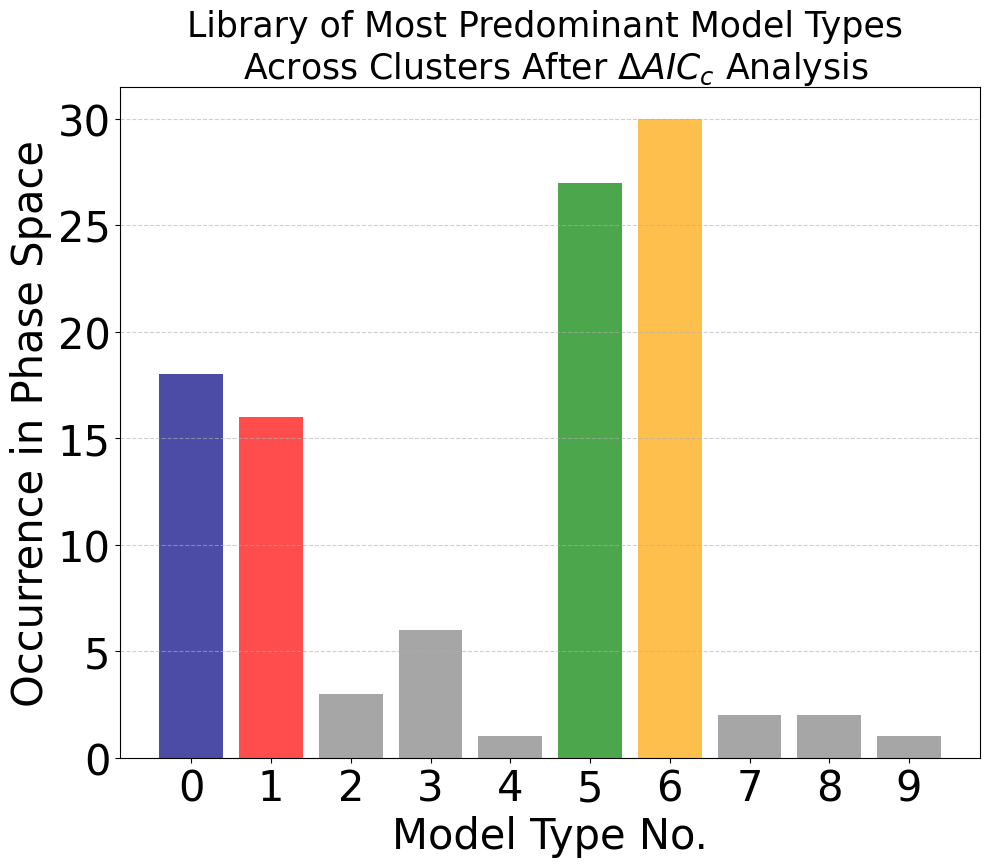

In [ ]:
unique_models_test_df = unique_filtered_df

# Predefined color list for occurrences > 2
color_above_2 = ['navy', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown', 'pink']

# Assign colors based on the threshold (>2) without repeating
color_iter = iter(color_above_2)
colors = [
    next(color_iter) if val > 7 else 'grey'
    for val in unique_models_test_df['occurrence']
]

# Create the bar plot
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
axs.bar(unique_models_test_df.index, unique_models_test_df['occurrence'], color=colors, alpha=0.7)

# Add labels and title
plt.xlabel('Model Type No.', fontsize=30)
plt.ylabel('Occurrence in Phase Space', fontsize=30)
x_ticks = range(0, len(unique_models_test_df.index), 1)
axs.set_xticks(x_ticks)
plt.xticks(rotation=0, fontsize=25)
axs.grid(axis='y', linestyle='--', alpha=0.6)
axs.tick_params(axis='both', which='major', labelsize=30)

# Display the plot
plt.tight_layout()

disp_plot_file_name = 'occurance_plot_with_found_features_X'

axs.set_title('Library of Most Predominant Model Types \n Across Clusters After $\Delta AIC_{c}$ Analysis', fontsize=25)

# plt.savefig(disp_plot_file_name + '.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# Simulation of results of best model types in the Phase Space

rms was: 4.445099225776108
switch_ind was: 178


'0.001544675 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + -0.007282700 (1-e1)^-2 + 0.022012900 (1-e1)^-3'

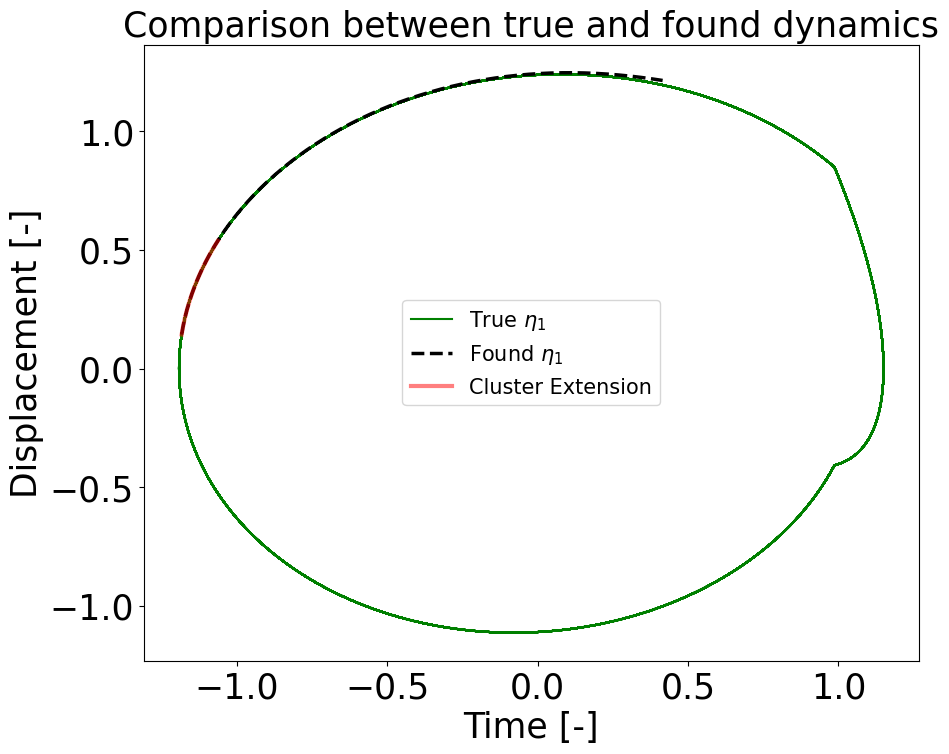

In [91]:
model_to_study = best_rel_AIC_c_C0_df['Candidate Model'][0]
cluster_to_test = 0

simulated_data_C0F, extended_val_trajec_C0F, F_ts_true_C0F, F_ts_sim_C0F = simulate_phase_space_from_most_freq_models_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= (1e-2)/2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 807, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2, 
                                                 plot = True, save=False)

model_to_study.equations(precision=9)[1]

rms was: 0.2837956397667953
switch_ind was: 2


'0.080943594 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + 0.358222436 (0.0132626-1+e1)^1.5 + -7.874649712 (0.0132626-1+e1)^2 + -14.805667299 (0.0132626-1+e1)^2.5'

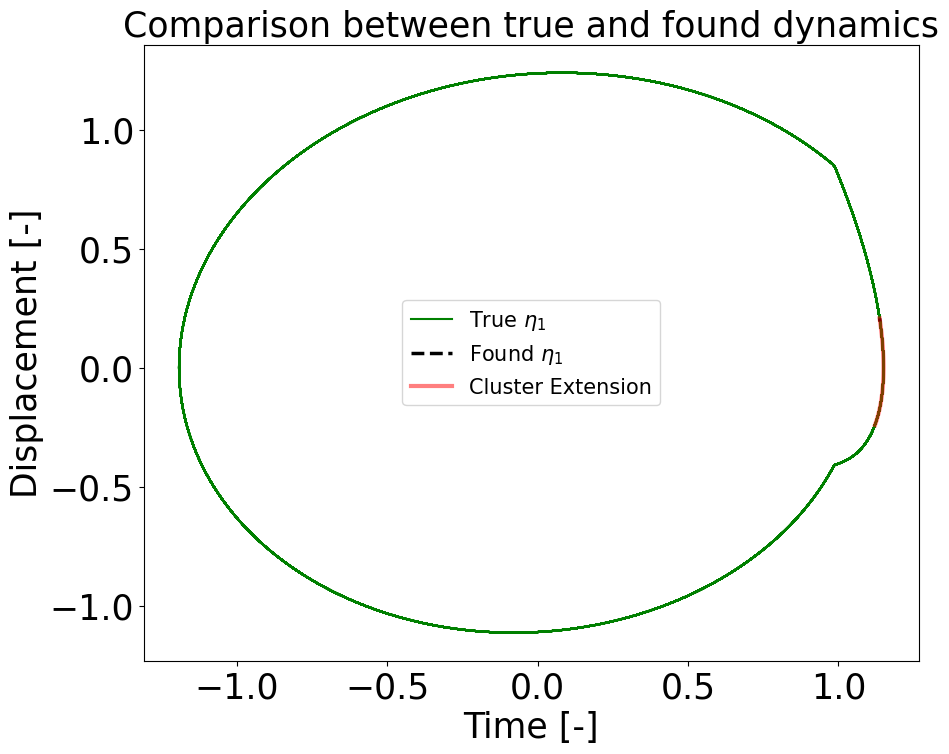

In [92]:
model_to_study = best_rel_AIC_c_C1_df['Candidate Model'][2] 
cluster_to_test = 1

simulated_data_C1F, extended_val_trajec_C1F, F_ts_true_C1F, F_ts_sim_C1F = simulate_phase_space_from_most_freq_models_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= (1e-2)/2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 807, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2,
                                                 plot = True, save=False)

model_to_study.equations(precision=9)[1]

rms was: 0.1353178064284579
switch_ind was: 191


'0.007270121 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase)'

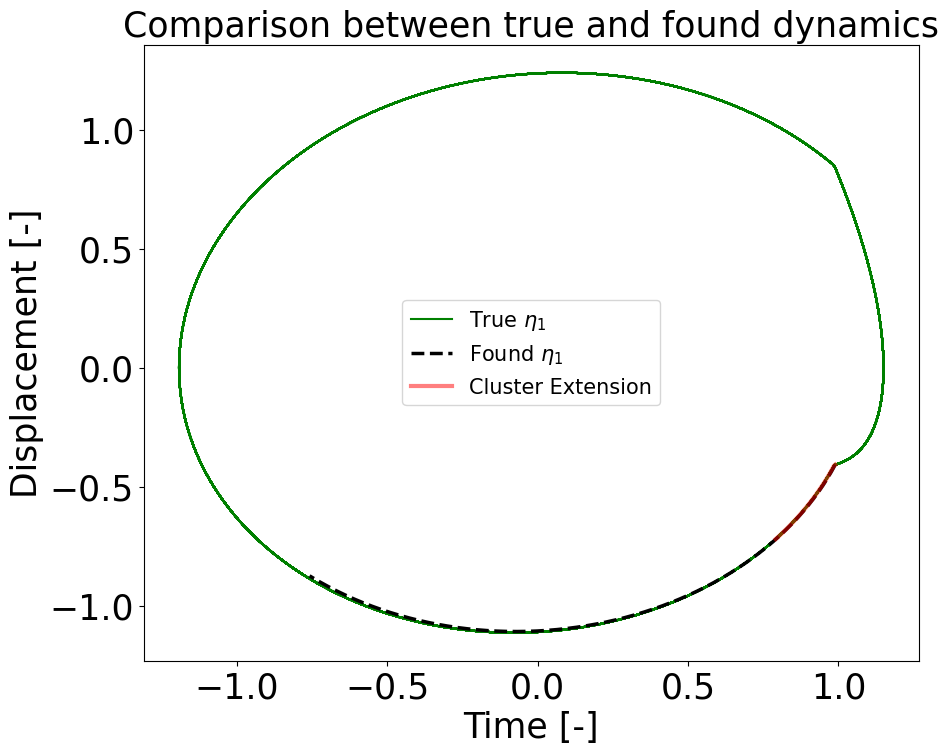

In [93]:
model_to_study = best_rel_AIC_c_C7_df['Candidate Model'][2] 
cluster_to_test = 7

simulated_data_C7F, extended_val_trajec_C7F, F_ts_true_C7F, F_ts_sim_C7F = simulate_phase_space_from_most_freq_models_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= (1e-2)/2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 807, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2,
                                                 plot = True, save=False)

model_to_study.equations(precision=9)[1]

rms was: 0.003503021104308081
switch_ind was: 525


'0.000016667 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + 0.000001242 (1-e1)^-2'

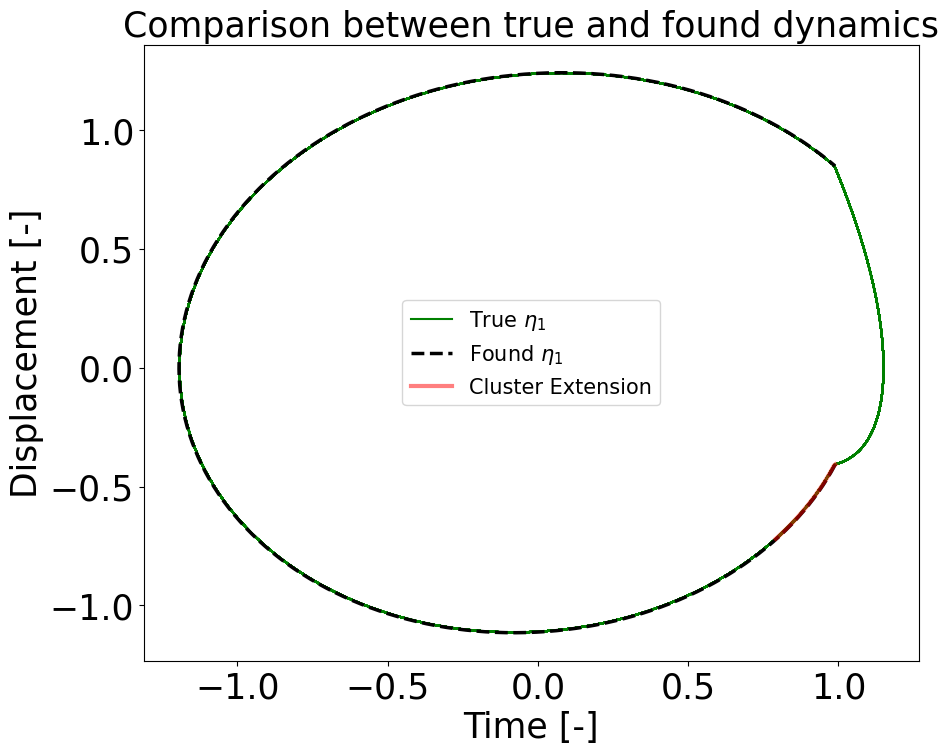

In [94]:
model_to_study = best_rel_AIC_c_C7_df['Candidate Model'][4]
cluster_to_test = 7

simulated_data_C7F2, extended_val_trajec_C7F2, F_ts_true_C7F2, F_ts_sim_C7F2 = simulate_phase_space_from_most_freq_models_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 525, model_type = 'Normal DMT',
                                                 a0=a0, C1=C1, C2=C2,
                                                 plot = True, save=False)

model_to_study.equations(precision=9)[1]

### Plotting all most prominent found model types

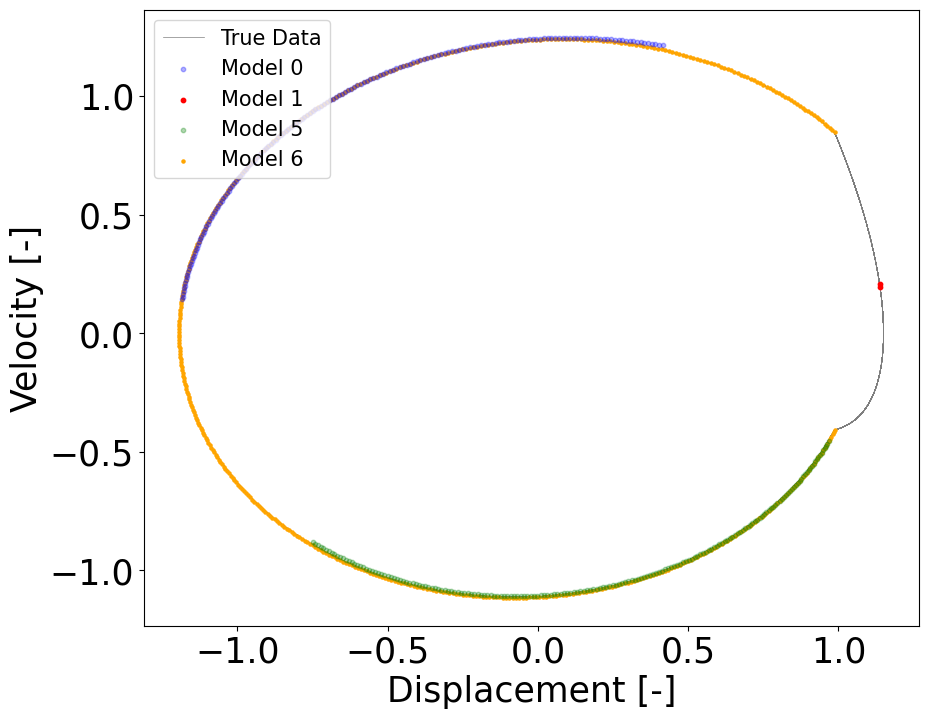

In [ ]:
set_plot_style()

fig, axs = plt.subplots(1, 1, figsize=(10, 8))
# Plot the gray points first with the lowest zorder
axs.plot(x_train_DMT_mult_traj[traject][-16000:,0], x_train_DMT_mult_traj[traject][-16000:,1], color='black', linewidth = 0.5, alpha = 0.5, label = 'True Data', zorder=1)
# Next, plot the other colors with increasing zorder values
axs.scatter(simulated_data_C0F[:, 0], simulated_data_C0F[:, 1], s=10, alpha = 0.3, color = 'blue', label = 'Model 0', zorder=3)
axs.scatter(simulated_data_C1F[:, 0], simulated_data_C1F[:, 1], s=10, color = 'red', label = 'Model 1', zorder=4)
axs.scatter(simulated_data_C7F[5:-1, 0], simulated_data_C7F[5:-1, 1], s=10, alpha = 0.3, color = 'green', label = 'Model 5', zorder=5)
# Make sure the orange points are on top of the gray but below others
axs.scatter(simulated_data_C7F2[:, 0], simulated_data_C7F2[:, 1], s=5, color = 'orange', label = 'Model 6', zorder=2)

axs.set_xlabel(r'Displacement [-]', fontsize=25)
axs.set_ylabel(r'Velocity [-]', fontsize=25)
axs.tick_params(axis='both', which='major', labelsize=25)
axs.legend(loc='upper left', fontsize=15)
# axs.set_title('AFM DMT Synthetic Data Phase Space with \n Most Predominant Model Types from Training Clusters', fontsize=20)

# Saving the figure with a transparent background
# plt.savefig('DMT_phase_space_found_models_simulations_no_title.png', transparent=True, dpi=300, bbox_inches='tight')

## Intermolecular distance

a0 = 0.9867374
Found a0 = 1.0312869
The error in estimating a0 is: 4.3198 %


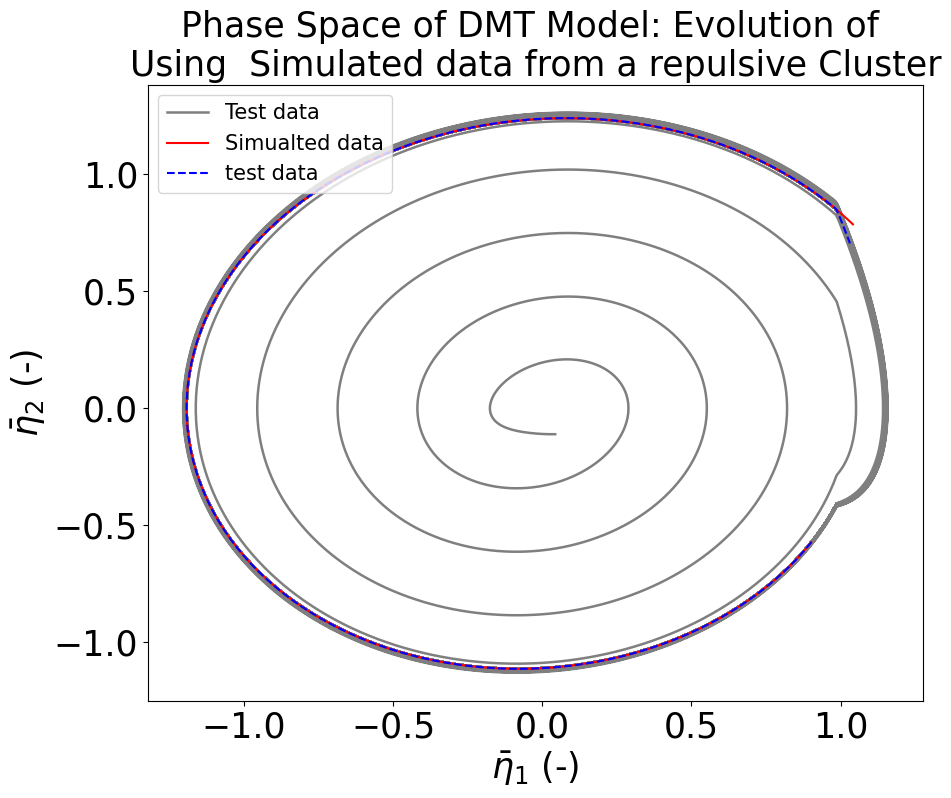

In [ ]:
model_to_study = best_rel_AIC_c_C7_df['Candidate Model'][4]
cluster_to_study = 7

test_traject = np.vstack((x_train_DMT_mult_traj[0][:,0], x_train_DMT_mult_traj[0][:,1], x_train_DMT_mult_traj[0][:,2])).T

a0_temp1, a0_temp_list1, a0_estimation_error1, error_list1, sim_found_model, x_test_reg_mult_traj = find_intermolecular_distance(found_SINDy_model=model_to_study, test_trajectory=test_traject, 
                                                                    x_train_synthetic_mult_traj=x_train_DMT_mult_traj, solve_ivp_method = 'BDF',
                                                                    analyzed_cluster = mult_traj_clusters_dots_list[traject][cluster_to_study], error_threshold = ((1e-2)/(2)),#((1e-2)/(2)), 1e-1, ((1e-3)/(1))
                                                                    init_cluster_size = 100, theoretical_a0=a0, plot_results = True,
                                                                    image_name = 'int_dist_calc_C3', save=False)

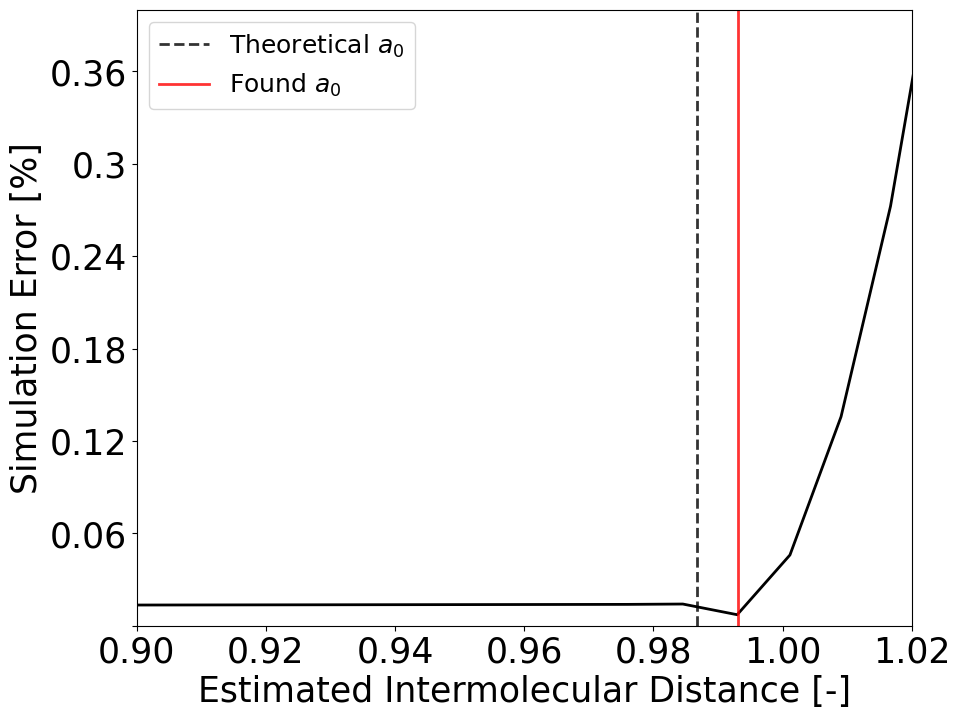

In [97]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

set_plot_style()

errors_percentage = [error * 100 for error in error_list1]

fig, axs = plt.subplots(1, 1, figsize=(10, 8))

axs.plot(a0_temp_list1, errors_percentage, color='black', alpha=1,linewidth=2)
axs.axvline(x=(1-a0), color='black', linestyle='--', label=f'Theoretical $a_0$', alpha=0.8,linewidth=2)
axs.axvline(x=(a0_temp1-(a0+0.025)), color='red', linestyle='-', label=f'Found $a_0$', alpha=0.8,linewidth=2)
axs.set_xlabel('Estimated Intermolecular Distance [-]', fontsize=25)
axs.set_ylabel('Simulation Error [%]', fontsize=25)
axs.xaxis.set_major_locator(MaxNLocator(nbins=7))
axs.yaxis.set_major_locator(MaxNLocator(nbins=7))
axs.legend(loc='upper left')
axs.set_xlim([0.9,1.02])
axs.set_ylim([0,0.4])

axs.set_yticklabels([label if label != 0 else '' for label in axs.get_yticks()]) #removes the zero from the origin of the y axis

# Adding legend and customizing ticks
axs.legend(loc='upper left', fontsize=18)
axs.tick_params(axis='both', which='major', labelsize=25)

# Saving the figure with a transparent background
# plt.savefig('sim_error_vs_intermolecular_dist_from_attractive.png', transparent=True, dpi=300, bbox_inches='tight')
plt.show()